In [3]:
from IPython.display import display
from IPython.core.display import HTML
%load_ext autoreload
%load_ext time
%autoreload 2
%autosave 60
%matplotlib inline

display(HTML("<style>.container { width:80% !important; }</style>"))

The time module is not an IPython extension.


Autosaving every 60 seconds


In [4]:
import pandas as pd
import numpy as np
import folium
import geojson
import geopandas
import contextily as cx
import osmnx as ox
import networkx as nx
import seaborn as sns
import geopy.distance
from pathlib import Path
from pyproj import CRS, Transformer
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

from exploration_utils import plot_counter, plot_counters, plot_locations, inspect_diff_area, plot_scatters
from exploration_utils import plot_speed_dayline, plot_flow_dayline, plot_kde_scatter
from exploration_utils import MOVIE_BBOXES


DATA_PATH = Path('/private/data/mets10/loop_counters')
RELEASE_PATH = Path('/private/data/mets10/release20221026_residential_unclassified')

In [14]:
speeds_merged_berlin = pd.read_parquet(DATA_PATH / 'berlin' / 'speeds_merged_clean_berlin.parquet')
print(len(speeds_merged_berlin))
speeds_merged_london = pd.read_parquet(DATA_PATH / 'london' / 'speeds_merged_clean_london.parquet')
print(len(speeds_merged_london))
speeds_merged_madrid = pd.read_parquet(DATA_PATH / 'madrid' / 'speeds_merged_clean_madrid.parquet')
print(len(speeds_merged_madrid))

12213
18839
9132


In [30]:
# _ = inspect_diff_area(speeds_merged_london, 0, 120, 0, 120, bbox_city='london')

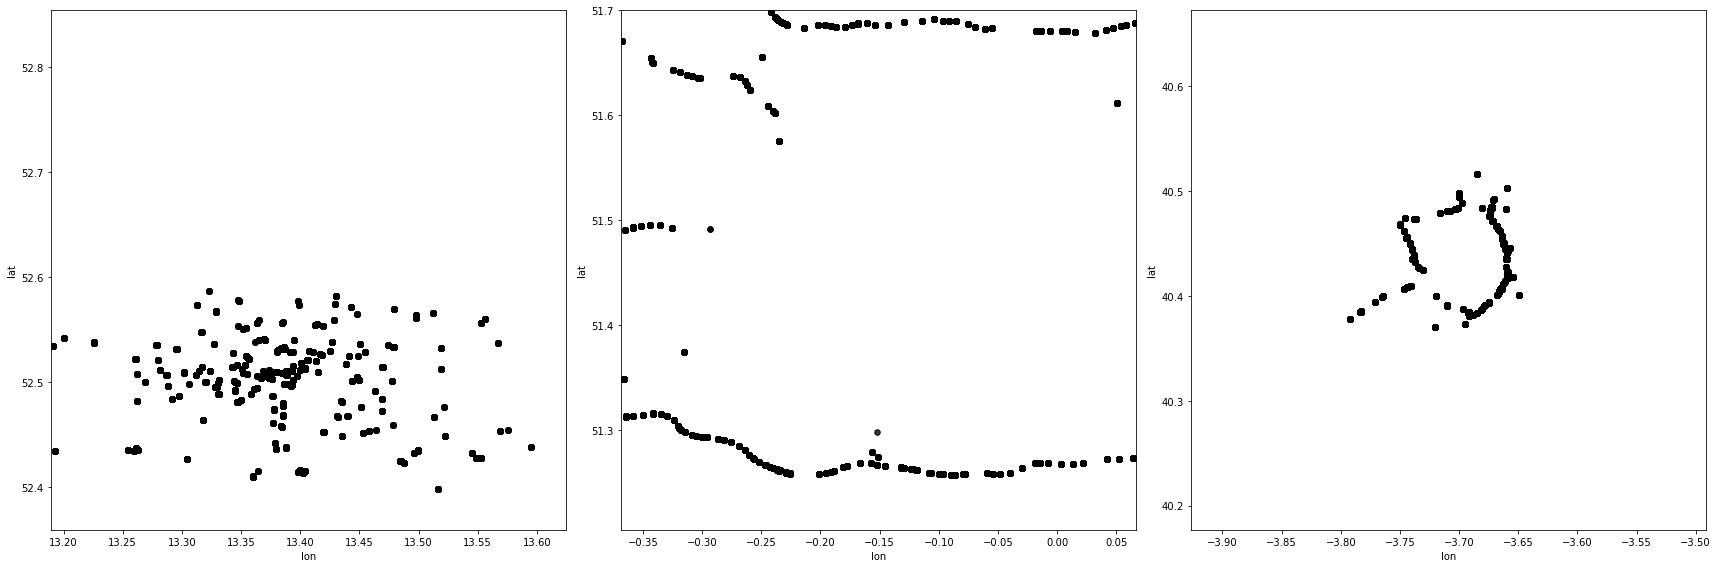

In [42]:
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(24,8))
plot_locations(speeds_merged_berlin, bbox_city='berlin', ax=axs[0])
plot_locations(speeds_merged_london, bbox_city='london', ax=axs[1])
plot_locations(speeds_merged_madrid, bbox_city='madrid', ax=axs[2])
plt.show()

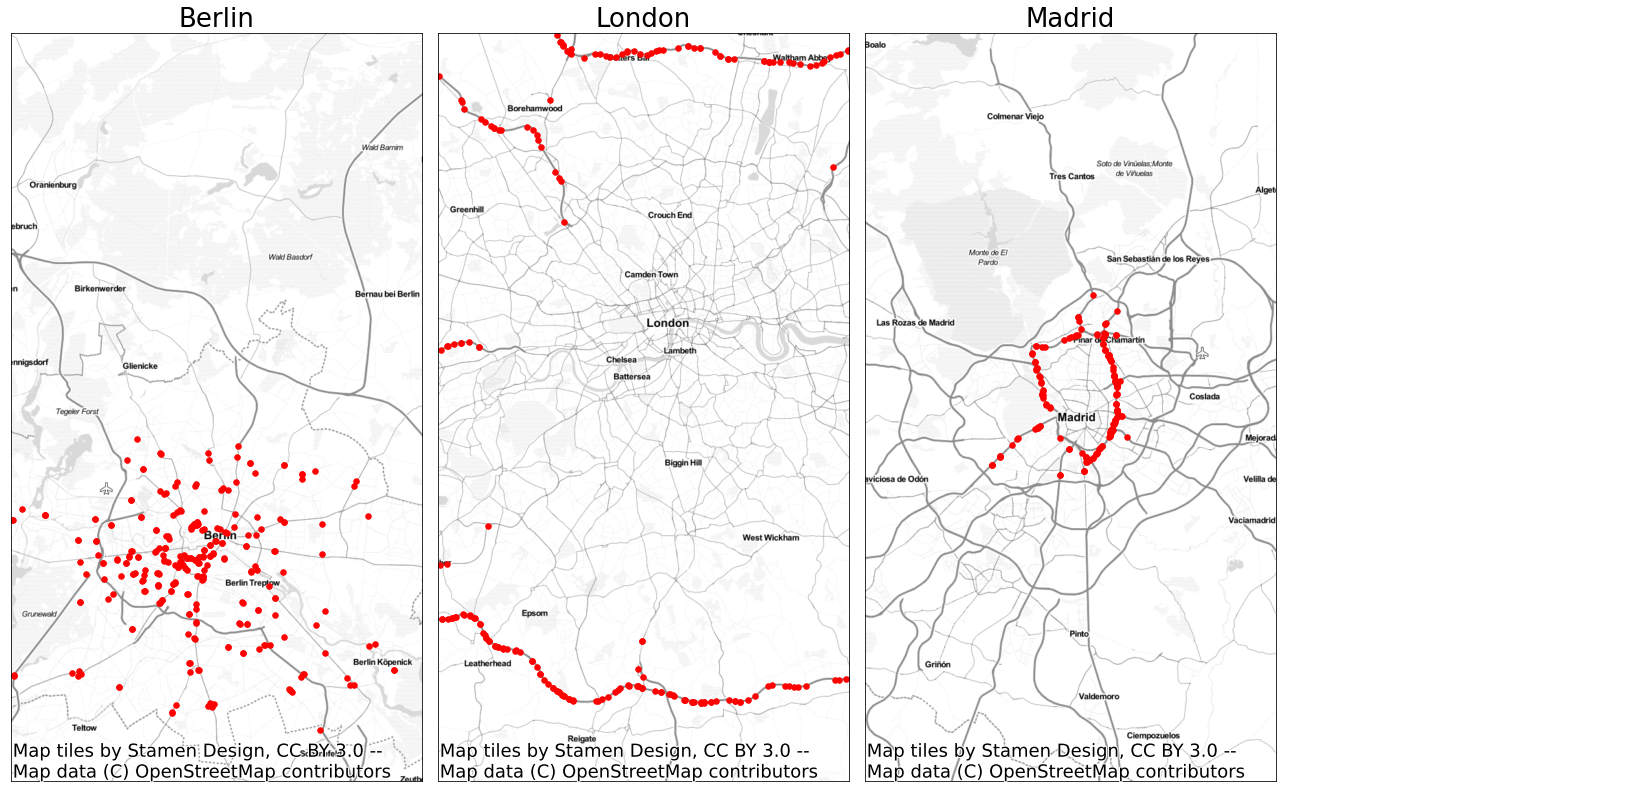

In [401]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

def plot_locations_map(df, city, ax=None):
    fig = None
    if not ax:
        fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(8,8))
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bbox = tuple([c / 1e5 for c in MOVIE_BBOXES[city.lower()]['bounds']])
    south, north, west, east = bbox
    lon_min, lat_min, lon_max, lat_max = transformer.transform_bounds(south, west, north, east)
    
    df = geopandas.GeoDataFrame(df.copy(), geometry=geopandas.points_from_xy(df.lon, df.lat))
    df = df.set_crs('EPSG:4326')
    df = df.to_crs(epsg=3857)
    if 'cnt' in df.columns:
        df.plot(column='cnt', markersize=30, cmap=plt.get_cmap("jet"), colorbar=True, alpha=0.4, ax=ax)
        plt.legend()
    else:
        df.plot(color="red", markersize=30, ax=ax)
    
    # Enlarge the lat bbox values to a span of 88426, this copes with the projection
    # size differences between the different latitudes. For visualization only.
    lat_mid = lat_min + ((lat_max - lat_min) / 2)
    lat_min = lat_mid - (88426 / 2)
    lat_max = lat_mid + (88426 / 2)
    
    ax.set_xlim([lon_min,lon_max])
    ax.set_ylim([lat_min,lat_max])
        
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, attribution_size=18)
    
    ax.title.set_text(city)
    ax.title.set_size(26)

    if fig:
        plt.show()


# plot_locations_map(speeds_merged_berlin, bbox_city='berlin')
# plot_locations_map(speeds_merged_london, bbox_city='london')
# plot_locations_map(speeds_merged_madrid, bbox_city='madrid')

fig, axs = plt.subplots(1, 3, tight_layout=False, figsize=(18,12))
fig.tight_layout(pad=0.0, w_pad=-1.5)
# plot_locations_map(speeds_merged_berlin, city='Berlin', ax=axs[0])
# plot_locations_map(speeds_merged_london, city='London', ax=axs[1])
# plot_locations_map(speeds_merged_madrid, city='Madrid', ax=axs[2])
plot_locations_map(speeds_merged_berlin[['lat', 'lon']].groupby(['lat', 'lon']).max().reset_index(), city='Berlin', ax=axs[0])
plot_locations_map(speeds_merged_london[['lat', 'lon']].groupby(['lat', 'lon']).max().reset_index(), city='London', ax=axs[1])
plot_locations_map(speeds_merged_madrid[['lat', 'lon']].groupby(['lat', 'lon']).max().reset_index(), city='Madrid', ax=axs[2])
plt.savefig('sxs_city_counter_map.pdf')

# attribution
# Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors

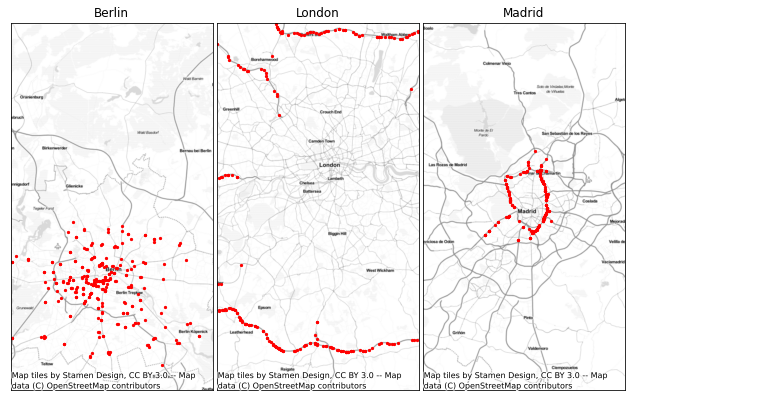

In [104]:
fig, axs = plt.subplots(1, 3, tight_layout=False, figsize=(9,6))
fig.tight_layout(pad=0.0, w_pad=-3.0)
plot_locations_map(speeds_merged_berlin[['lat', 'lon']].groupby(['lat', 'lon']).max().reset_index(), city='Berlin', ax=axs[0])
plot_locations_map(speeds_merged_london[['lat', 'lon']].groupby(['lat', 'lon']).max().reset_index(), city='London', ax=axs[1])
plot_locations_map(speeds_merged_madrid[['lat', 'lon']].groupby(['lat', 'lon']).max().reset_index(), city='Madrid', ax=axs[2])
plt.savefig('sxs_city_counter_map.pdf')  

In [77]:
def print_bbox_meters(city):
    bbox = tuple([c / 1e5 for c in MOVIE_BBOXES[city]['bounds']])
    south, north, west, east = bbox
    print(f'{city} ({east - west}, {north - south})')
#     print((north, west))
#     print((north, east))
    print(f'width: {geopy.distance.geodesic((north, west), (north, east)).km} km')
    print(f'height: {geopy.distance.geodesic((north, west), (south, west)).km} km\n')
    
# print_bbox_meters('berlin')
# print_bbox_meters('london')
# print_bbox_meters('madrid')

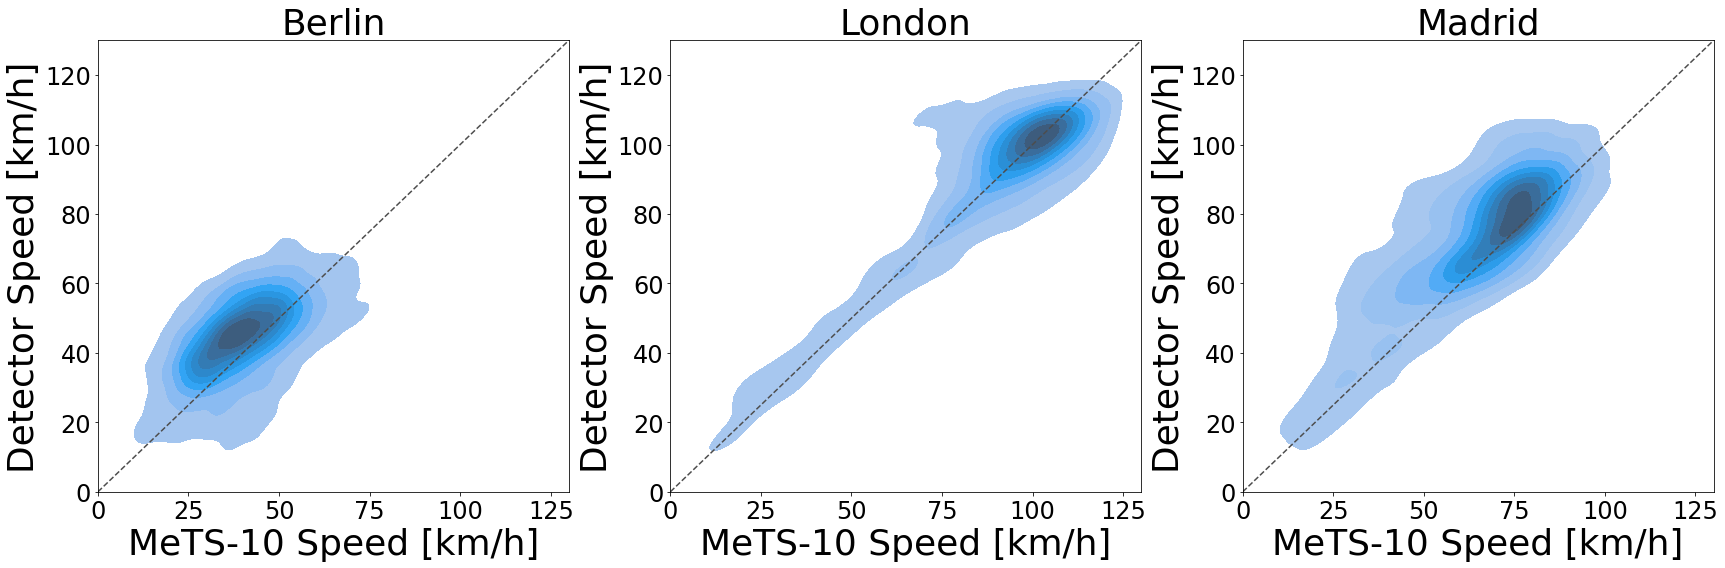

In [151]:
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(24,8))
plot_kde_scatter(speeds_merged_berlin, ax=axs[0], city='Berlin')
plot_kde_scatter(speeds_merged_london, ax=axs[1], city='London')
plot_kde_scatter(speeds_merged_madrid, ax=axs[2], city='Madrid')
plt.show()

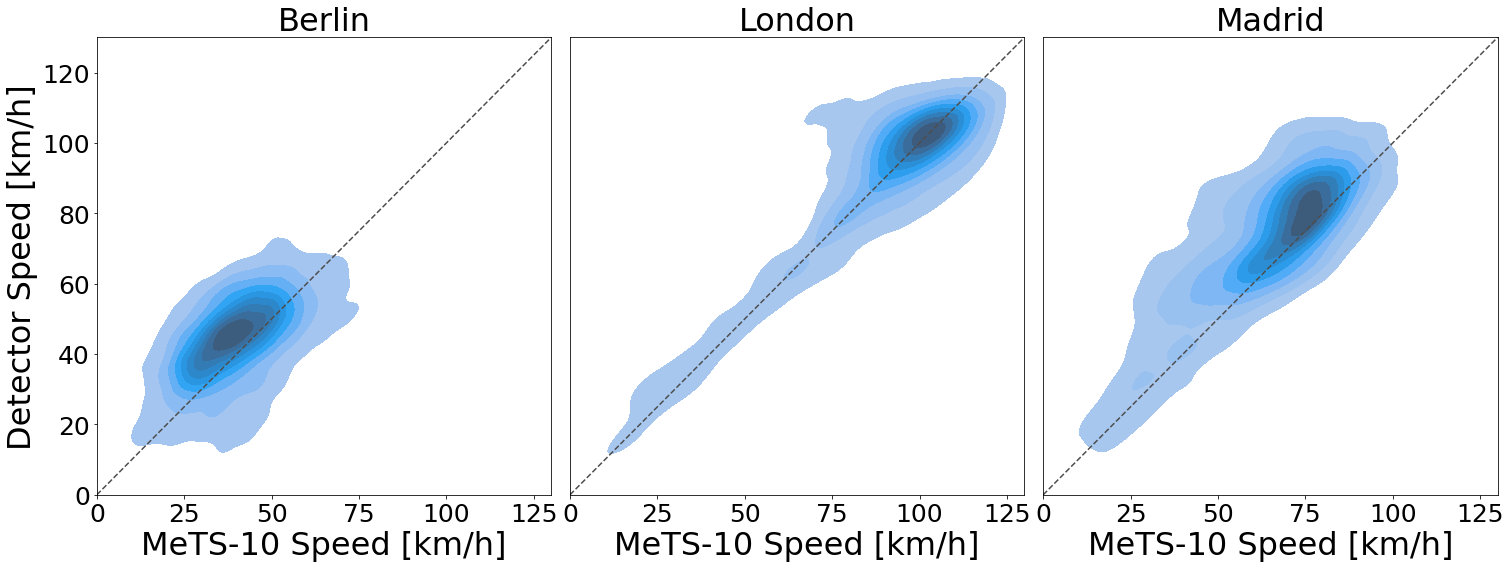

In [172]:
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(21,8))
plot_kde_scatter(speeds_merged_berlin, ax=axs[0], labelsize=25, titlesize=32, city='Berlin')
plot_kde_scatter(speeds_merged_london, ax=axs[1], labelsize=25, titlesize=32, city='London')
plot_kde_scatter(speeds_merged_madrid, ax=axs[2], labelsize=25, titlesize=32, city='Madrid')
axs[1].get_yaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)
plt.savefig("sxs_snsspeed.png")
plt.savefig("sxs_snsspeed.pdf")

array([[<AxesSubplot:title={'center':'diff'}>,
        <AxesSubplot:title={'center':'diff_perc'}>]], dtype=object)

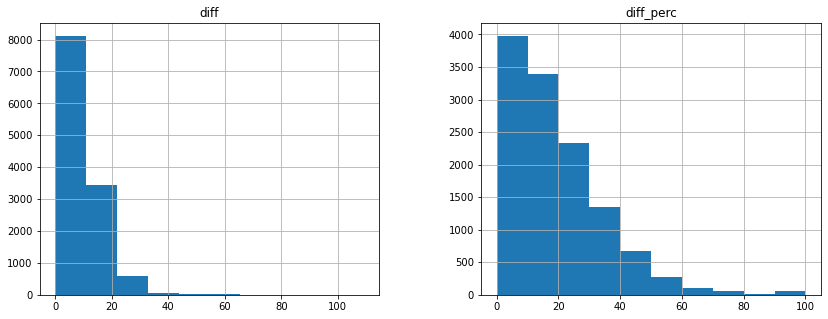

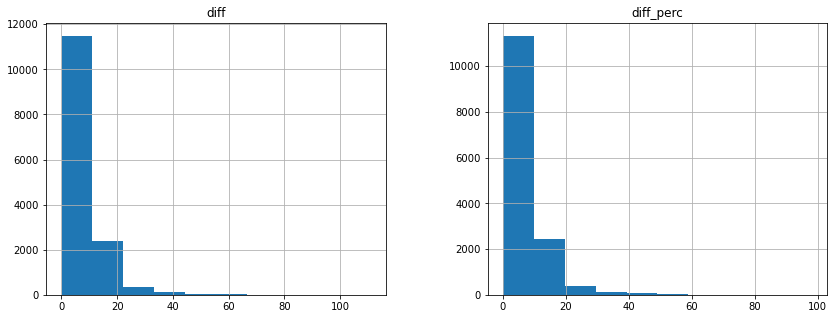

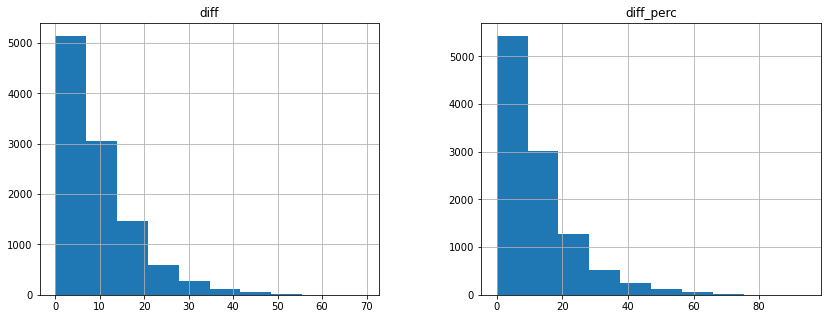

In [5]:
speeds_merged_berlin['diff_perc'] = (speeds_merged_berlin['diff'] / speeds_merged_berlin['free_flow_kph']) * 100
speeds_merged_berlin['diff_perc'].clip(upper=100, inplace=True)  
speeds_merged_berlin[['diff', 'diff_perc']].hist(figsize=(14,5))
speeds_merged_london['diff_perc'] = (speeds_merged_london['diff'] / speeds_merged_london['free_flow_kph']) * 100
speeds_merged_london['diff_perc'].clip(upper=100, inplace=True)  
speeds_merged_london[['diff', 'diff_perc']].hist(figsize=(14,5))
speeds_merged_madrid['diff_perc'] = (speeds_merged_madrid['diff'] / speeds_merged_madrid['free_flow_kph']) * 100
speeds_merged_madrid['diff_perc'].clip(upper=100, inplace=True)  
speeds_merged_madrid[['diff', 'diff_perc']].hist(figsize=(14,5))

In [10]:
edges_berlin = geopandas.read_parquet(RELEASE_PATH / '2021' / 'road_graph' / 'berlin' / 'road_graph_edges.parquet')
speeds_merged_berlin = speeds_merged_berlin.merge(edges_berlin[['u', 'v', 'gkey', 'highway']], on=['u', 'v', 'gkey'])
print(len(speeds_merged_berlin))
# edges_london = geopandas.read_parquet(RELEASE_PATH / '2022' / 'road_graph' / 'london' / 'road_graph_edges.parquet')
# speeds_merged_london = speeds_merged_london.merge(edges_london[['u', 'v', 'gkey', 'highway']], on=['u', 'v', 'gkey'])
# print(len(speeds_merged_london))
edges_madrid = geopandas.read_parquet(RELEASE_PATH / '2022' / 'road_graph' / 'madrid' / 'road_graph_edges.parquet')
speeds_merged_madrid = speeds_merged_madrid.merge(edges_madrid[['u', 'v', 'gkey', 'highway']], on=['u', 'v', 'gkey'])
print(len(speeds_merged_madrid))

12213
9132


In [11]:
# speeds_merged_berlin['diff_rat'] = ((speeds_merged_berlin['speed_probes'] - speeds_merged_berlin['speed_counter']) / 120).astype(float)
speeds_merged_berlin.head()

,id,tag,stunde,qualitaet,q_kfz_det_hr,v_kfz_det_hr,q_pkw_det_hr,v_pkw_det_hr,q_lkw_det_hr,v_lkw_det_hr,...,gkey,volume_class,volume_y,speed_probes,mean_speed_kph,std_speed_kph,free_flow_kph,diff,highway_x,highway_y
0,100101010000167,05.06.2019,0,1.0,259,74.3,223,74.9,36,71.0,...,-8786241051327056030,5.0,163.250000,90.274510,86.901664,12.106970,95.215686,15.974510,motorway,motorway
1,100101010000167,05.06.2019,1,1.0,125,72.2,96,76.3,29,58.7,...,-8786241051327056030,5.0,91.000000,91.539216,87.254902,13.405553,95.215686,19.339216,motorway,motorway
2,100101010000167,05.06.2019,2,1.0,108,67.8,63,76.7,45,55.4,...,-8786241051327056030,5.0,62.666667,90.810458,91.515152,9.404753,95.215686,23.010458,motorway,motorway
3,100101010000167,05.06.2019,3,1.0,125,69.0,89,72.0,36,61.5,...,-8786241051327056030,5.0,41.000000,94.147059,94.285146,4.401606,95.215686,25.147059,motorway,motorway
4,100101010000167,05.06.2019,4,1.0,224,70.6,165,72.9,59,64.2,...,-8786241051327056030,5.0,119.250000,100.686275,95.632947,19.957391,95.215686,30.086275,motorway,motorway


In [15]:
# speeds_merged_london['diff_rat'] = ((speeds_merged_london['speed_probes'] - speeds_merged_london['speed_counter']) / 120).astype(float)
speeds_merged_london.head()

,id,name,lat,lon,heading,time_bin,volume_x,speed_counter,t,day_x,...,osmid,day_y,volume_class,volume_y,speed_probes,mean_speed_kph,std_speed_kph,free_flow_kph,diff,highway
0,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:15,83,91.73238,0,2020-01-29,...,"[2714200, 108688595]",2020-01-29,5,23.0,95.058824,85.593137,27.649474,112.0,3.326444,motorway
1,1040,M25/4451A,51.261609,-0.118224,-1,2020-01-29 00:15,94,102.99776,0,2020-01-29,...,"[2714200, 108688595]",2020-01-29,5,23.0,95.058824,85.593137,27.649474,112.0,7.938936,motorway
2,1476,M25/4459A,51.263198,-0.123678,-1,2020-01-29 00:15,82,102.99776,0,2020-01-29,...,"[2714200, 108688595]",2020-01-29,5,23.0,95.058824,85.593137,27.649474,112.0,7.938936,motorway
3,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:30,73,96.56040,1,2020-01-29,...,"[2714200, 108688595]",2020-01-29,5,13.0,91.764706,83.152941,36.571125,112.0,4.795694,motorway
4,1040,M25/4451A,51.261609,-0.118224,-1,2020-01-29 00:30,77,101.38842,1,2020-01-29,...,"[2714200, 108688595]",2020-01-29,5,13.0,91.764706,83.152941,36.571125,112.0,9.623714,motorway


In [130]:
# speeds_merged_madrid['diff_rat'] = ((speeds_merged_madrid['speed_probes'] - speeds_merged_madrid['speed_counter']) / 120).astype(float)
speeds_merged_madrid.head()

,id,lat,lon,heading,time_bin,type,volume,occupation,congestion_level,speed_counter,...,day,way,u,v,gkey,volume_class,speed_probes,free_flow_kph,diff,highway
0,1001,40.409729,-3.740786,62.428189,2021-06-01 06:15,M30,420,1.0,0.0,68.0,...,2021-06-01,44618925,315520338,315518315,3574882923521430049,5,62.352941,61.647059,5.647059,motorway
1,1001,40.409729,-3.740786,62.428189,2021-06-01 06:30,M30,420,1.0,0.0,68.0,...,2021-06-01,44618925,315520338,315518315,3574882923521430049,5,47.137255,61.647059,20.862745,motorway
2,1001,40.409729,-3.740786,62.428189,2021-06-01 06:45,M30,420,1.0,0.0,68.0,...,2021-06-01,44618925,315520338,315518315,3574882923521430049,5,63.843137,61.647059,4.156863,motorway
3,1001,40.409729,-3.740786,62.428189,2021-06-01 07:00,M30,420,1.0,0.0,68.0,...,2021-06-01,44618925,315520338,315518315,3574882923521430049,5,62.039216,61.647059,5.960784,motorway
4,1001,40.409729,-3.740786,62.428189,2021-06-01 07:15,M30,420,1.0,0.0,68.0,...,2021-06-01,44618925,315520338,315518315,3574882923521430049,5,56.784314,61.647059,11.215686,motorway


In [45]:
def osm_color_palette():
    for c in ["#e892a2", "#e892a2", "#f9b29c", "#f9b29c", "#fcd6a4", "#fcd6a4", "#f7fabf", "#f7fabf"] + ["white"] * 99:
        yield c

highway_ordering = [
    'motorway', 'motorway_link', 
    'trunk','trunk_link', 
    'primary','primary_link',
    'secondary', 'secondary_link', 
    'tertiary','tertiary_link',
    'unclassified',  'residential',
    'living_street', 'service',
    'cycleway', 'road', 'construction'
]
        
def diff_boxplot(data, ax=None, labelsize=24, city='', y_label='Speed diff (MeTS-10 - Detector) [km/h]', speed_field='speed_probes'):
    data = data[~data['highway'].str.contains('_link')].copy()
    data.loc[data["highway"].str.contains('motorway'), "highway"] = "motorway"
    data.loc[data["highway"].str.contains('trunk'), "highway"] = "trunk"
    data.loc[data["highway"].str.contains('primary'), "highway"] = "primary"
    data["sort_key"] = [highway_ordering.index(hw) for hw in data["highway"]]
    data = data.sort_values("sort_key")
    data["diff_km"] = data[speed_field] - data['speed_counter']
    if not ax:
        fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
    sns.boxplot(data=data, 
                x="highway",
                y="diff_km",  
                notch=True, 
                sym='',
                order=['motorway', 'trunk', 'primary', 'secondary', 'tertiary'],
                palette=osm_color_palette(),
                medianprops={"color": "coral"},
                ax=ax)
    ax.set(ylim=(-56, 56))
    ax.set_xlabel('road type (highway)', fontsize=labelsize)
    ax.set_ylabel(y_label, fontsize=labelsize)
    ax.tick_params(axis='x', which='major', labelsize=labelsize, rotation=45)
    ax.tick_params(axis='y', which='major', labelsize=labelsize)
    ax.grid(axis='y')
    ax.title.set_text(city)
    ax.title.set_size(labelsize+4)

In [ ]:
diff_boxplot(speeds_merged_berlin, city='Berlin')
# plt.savefig("London_counter_density_diff_barplot.png")
# speeds_merged_berlin['diff_rat'].min()

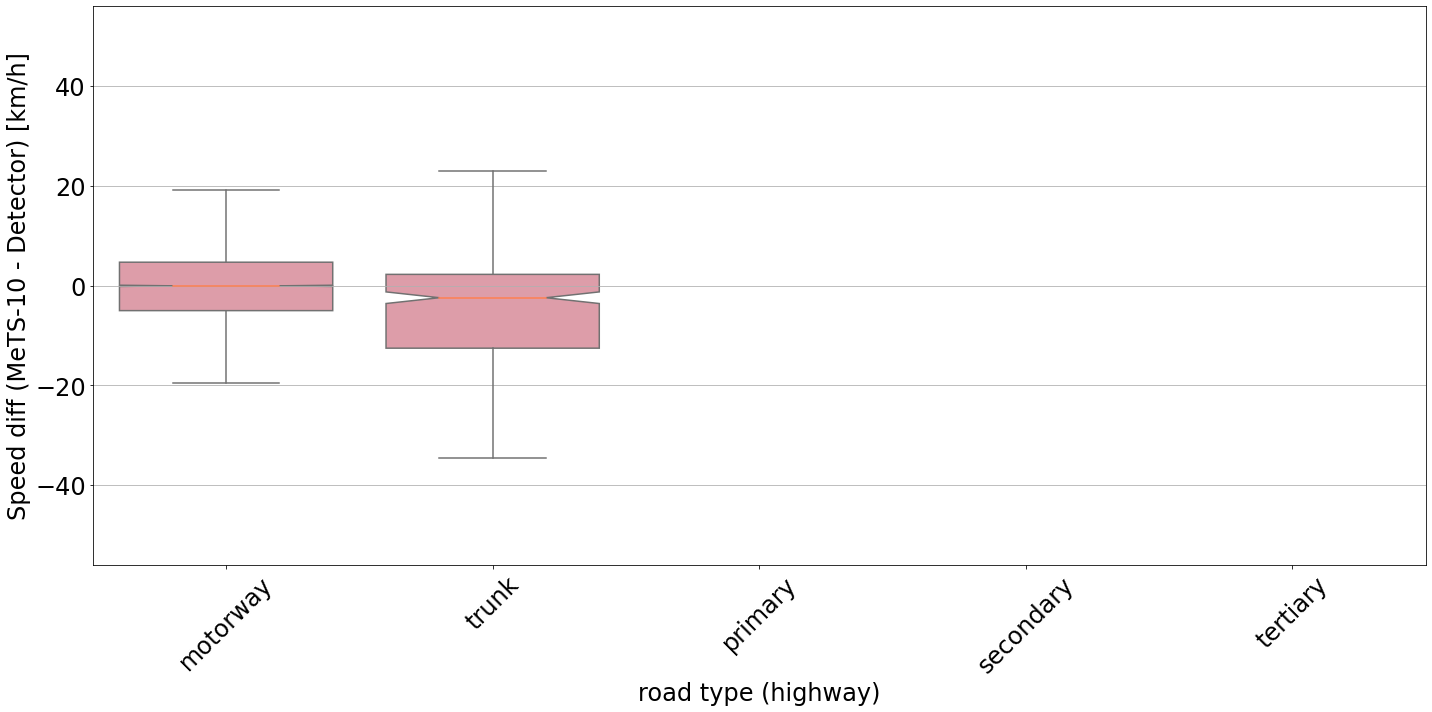

In [142]:
diff_boxplot(speeds_merged_london)

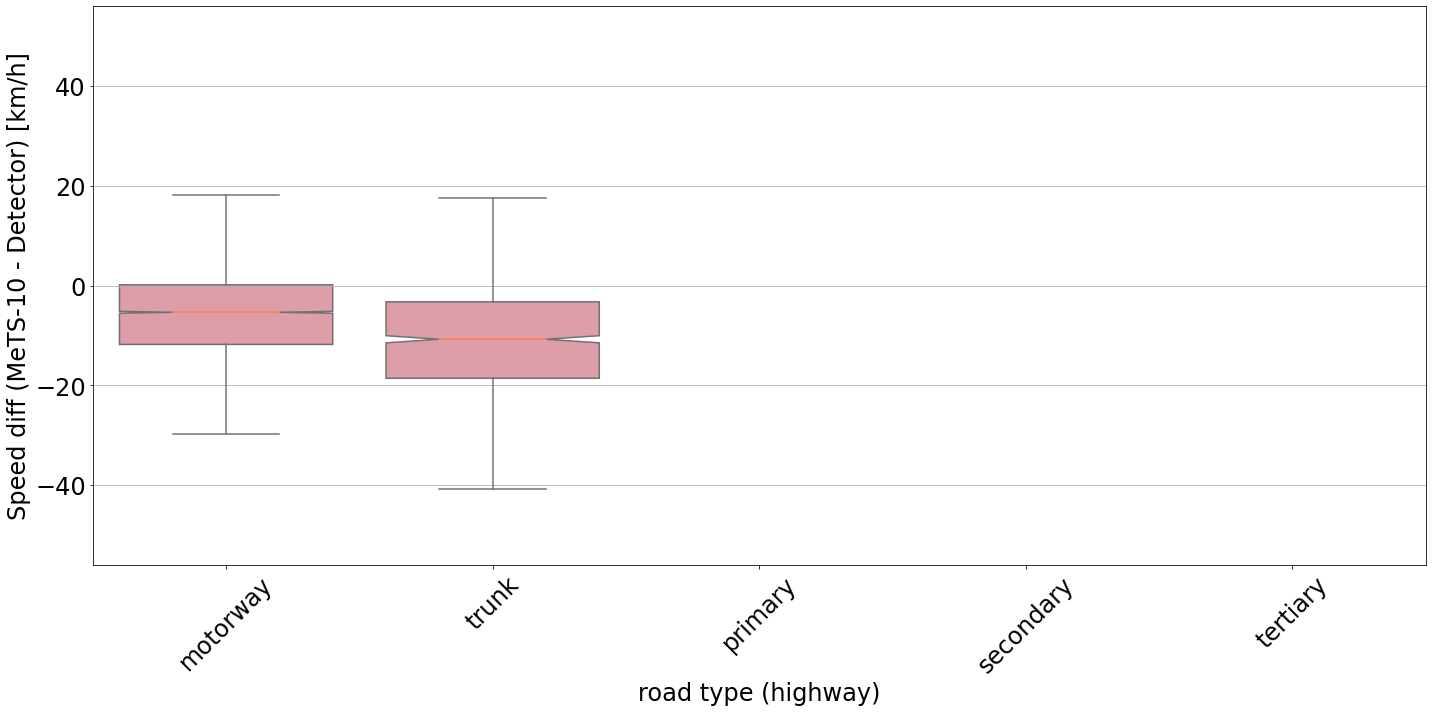

In [143]:
diff_boxplot(speeds_merged_madrid)

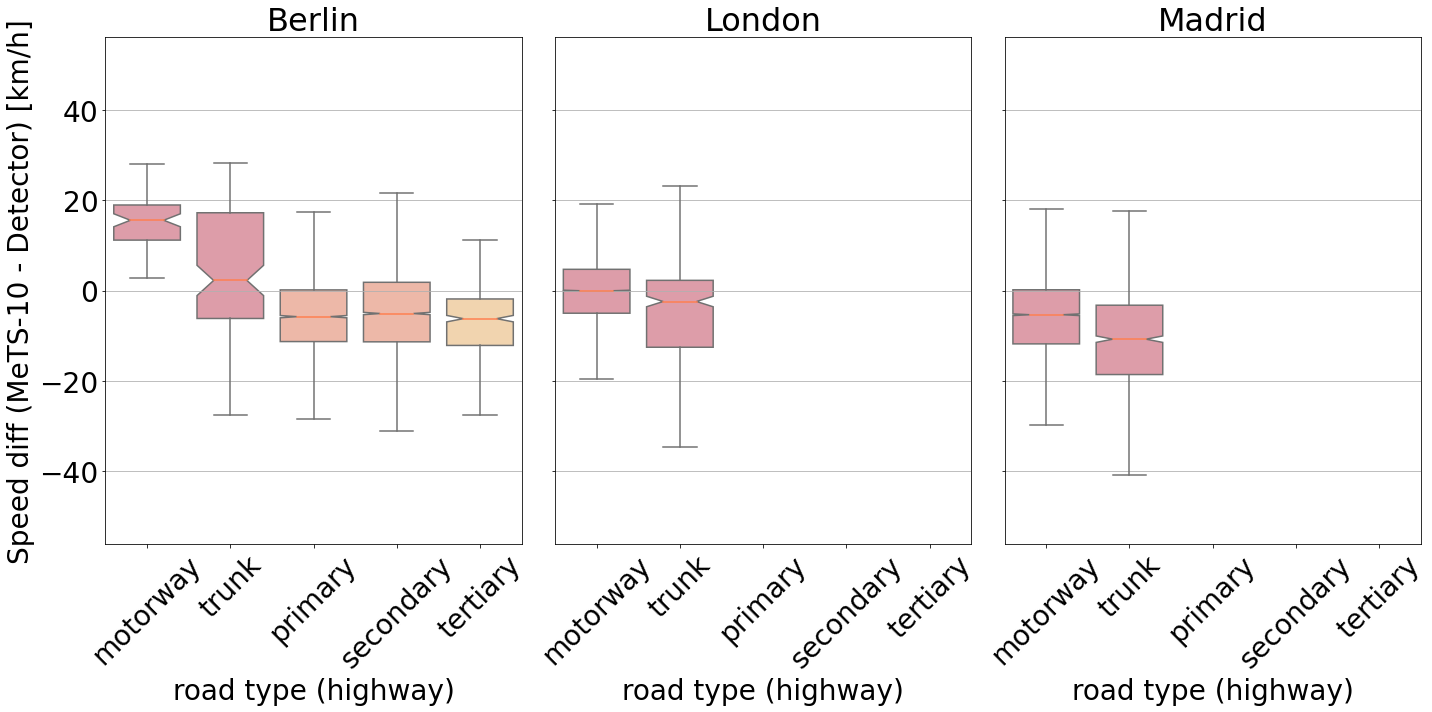

In [173]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10), tight_layout=True)
diff_boxplot(speeds_merged_berlin, axs[0], labelsize=28, city='Berlin')
diff_boxplot(speeds_merged_london, axs[1], labelsize=28, city='London')
diff_boxplot(speeds_merged_madrid, axs[2], labelsize=28, city='Madrid')
axs[1].get_yaxis().set_ticklabels([])
axs[2].get_yaxis().set_ticklabels([])
axs[1].set_ylabel('')
axs[2].set_ylabel('')
plt.savefig("counter_diff_boxplot.png")
plt.savefig("counter_diff_boxplot.pdf")

In [21]:
speeds_merged_berlin['diff_km'] = speeds_merged_berlin['speed_probes'] - speeds_merged_berlin['speed_counter']
diff_g0_berlin = speeds_merged_berlin[speeds_merged_berlin['diff_km'] > 0]
diff_g0_berlin

,id,tag,stunde,qualitaet,q_kfz_det_hr,v_kfz_det_hr,q_pkw_det_hr,v_pkw_det_hr,q_lkw_det_hr,v_lkw_det_hr,...,u,v,gkey,volume_class,speed_probes,free_flow_kph,diff,diff_perc,diff_km,highway
0,100101010000167,05.06.2019,0,1.0,259,74.3,223,74.9,36,71.0,...,484310,27088394,-7876585987730032488,5.0,91.539216,96.313725,17.239216,17.899023,17.239216,motorway
1,100101010000167,05.06.2019,1,1.0,125,72.2,96,76.3,29,58.7,...,484310,27088394,-7876585987730032488,5.0,90.810458,96.313725,18.610458,19.322747,18.610458,motorway
2,100101010000167,05.06.2019,2,1.0,108,67.8,63,76.7,45,55.4,...,484310,27088394,-7876585987730032488,5.0,94.147059,96.313725,26.347059,27.355456,26.347059,motorway
3,100101010000167,05.06.2019,3,1.0,125,69.0,89,72.0,36,61.5,...,484310,27088394,-7876585987730032488,5.0,100.686275,96.313725,31.686275,32.899023,31.686275,motorway
4,100101010000167,05.06.2019,4,1.0,224,70.6,165,72.9,59,64.2,...,484310,27088394,-7876585987730032488,5.0,96.647059,96.313725,26.047059,27.043974,26.047059,motorway
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12136,100101010097975,05.06.2019,19,1.0,483,30.0,465,30.2,18,25.6,...,727384652,29653738,6290654529955093163,5.0,31.833333,38.745098,1.833333,4.731781,1.833333,primary
12141,100101010097874,05.06.2019,22,1.0,227,34.2,225,34.3,2,17.0,...,727384652,29653738,6290654529955093163,5.0,36.058824,38.745098,1.858824,4.797571,1.858824,primary
12142,100101010097975,05.06.2019,22,1.0,292,35.3,290,35.4,2,19.5,...,727384652,29653738,6290654529955093163,5.0,36.058824,38.745098,0.758824,1.958502,0.758824,primary
12145,100101010099692,05.06.2019,0,1.0,16,18.3,16,18.3,0,-1.0,...,26736196,26736127,-3323162428936997225,5.0,35.205882,38.588235,16.905882,43.810976,16.905882,secondary


<AxesSubplot:>

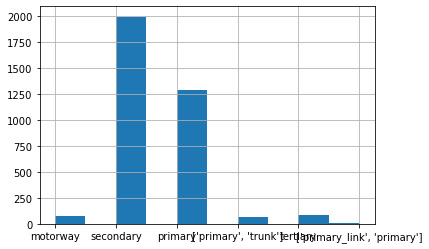

In [20]:
diff_g0_berlin['highway'].hist()

In [23]:
diff_g0mwt_berlin = diff_g0_berlin[(diff_g0_berlin['highway'].str.contains('motorway')) |
                                   (diff_g0_berlin['highway'].str.contains('trunk'))]
diff_g0mwt_berlin

,id,tag,stunde,qualitaet,q_kfz_det_hr,v_kfz_det_hr,q_pkw_det_hr,v_pkw_det_hr,q_lkw_det_hr,v_lkw_det_hr,...,u,v,gkey,volume_class,speed_probes,free_flow_kph,diff,diff_perc,diff_km,highway
0,100101010000167,05.06.2019,0,1.0,259,74.3,223,74.9,36,71.0,...,484310,27088394,-7876585987730032488,5.0,91.539216,96.313725,17.239216,17.899023,17.239216,motorway
1,100101010000167,05.06.2019,1,1.0,125,72.2,96,76.3,29,58.7,...,484310,27088394,-7876585987730032488,5.0,90.810458,96.313725,18.610458,19.322747,18.610458,motorway
2,100101010000167,05.06.2019,2,1.0,108,67.8,63,76.7,45,55.4,...,484310,27088394,-7876585987730032488,5.0,94.147059,96.313725,26.347059,27.355456,26.347059,motorway
3,100101010000167,05.06.2019,3,1.0,125,69.0,89,72.0,36,61.5,...,484310,27088394,-7876585987730032488,5.0,100.686275,96.313725,31.686275,32.899023,31.686275,motorway
4,100101010000167,05.06.2019,4,1.0,224,70.6,165,72.9,59,64.2,...,484310,27088394,-7876585987730032488,5.0,96.647059,96.313725,26.047059,27.043974,26.047059,motorway
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5456,100101010040785,05.06.2019,19,1.0,157,59.0,147,59.7,10,47.7,...,26970118,29422506,5914635569890360529,5.0,70.392157,76.078431,11.392157,14.974227,11.392157,"['primary', 'trunk']"
5458,100101010040785,05.06.2019,20,1.0,91,62.6,85,62.6,6,62.5,...,26970118,29422506,5914635569890360529,5.0,73.529412,76.078431,10.929412,14.365979,10.929412,"['primary', 'trunk']"
5460,100101010040785,05.06.2019,21,1.0,77,58.4,77,58.4,0,-1.0,...,26970118,29422506,5914635569890360529,5.0,71.235294,76.078431,12.835294,16.871134,12.835294,"['primary', 'trunk']"
5462,100101010040785,05.06.2019,22,1.0,34,57.6,34,57.6,0,-1.0,...,26970118,29422506,5914635569890360529,5.0,66.941176,76.078431,9.341176,12.278351,9.341176,"['primary', 'trunk']"


In [47]:
for i in diff_g0mwt_berlin[['id', 'name', 'lat', 'lon']].groupby(['id', 'name', 'lat', 'lon']).count().reset_index().iterrows():
    print(f"{i[1][0]}: {i[1][2]}, {i[1][3]}")

diff_g0mwt_berlin['id'].unique()

100101010000167: 52.43386833, 13.19257786
100101010000369: 52.43381256, 13.1927467
100101010000470: 52.43381256, 13.1927467
100101010004312: 52.57461381, 13.42952123
100101010004413: 52.57461381, 13.42952123
100101010004514: 52.57461381, 13.42952123
100101010040785: 52.58194883, 13.42993792
100101010040987: 52.58194883, 13.42993792


array([100101010000167, 100101010000369, 100101010000470, 100101010004312,
       100101010004413, 100101010004514, 100101010040785, 100101010040987])

In [29]:
hwt_ids = [
    100101010000167,  # Spanische Allebrücke, 52.43386833, 13.19257786 --> change from speed limit 100 to 80!
    100101010000369, 100101010000470, # Spanische Allebrücke, 52.43381256, 13.1927467 --> change from speed limit 100 to 80!
    100101010004312, 100101010004413, 100101010004514, # Prenzlauer Promenade/Pankow, 52.57461381, 13.42952123
    100101010040785, 100101010040987]  # Prenzlauer Promenade/Pasewalker Strasse, 52.58194883, 13.42993792

diff_g0mwt_berlin[['id', 'v_kfz_det_hr', 'v_pkw_det_hr', 'speed_probes', 'diff_km']].groupby('id').agg(
    {'v_kfz_det_hr': ['mean', 'std'],
     'v_pkw_det_hr': ['mean', 'std'],
     'speed_probes': ['mean', 'std'],
     'diff_km': ['mean', 'std', 'count']})

v_kfz_det_hr            v_pkw_det_hr           speed_probes  \
                        mean        std         mean       std         mean   
id                                                                            
100101010000167    71.758333   6.787835    72.875000  7.244383    90.406318   
100101010000369    73.925000   6.344683    77.687500  6.602853    89.436275   
100101010000470    76.579167   4.131952    77.929167  4.399751    89.436275   
100101010004312    48.041667   3.031131    48.775000  2.960941    68.856618   
100101010004413    64.752941   4.573308    69.311765  1.616277    70.664937   
100101010004514    70.200000        NaN    70.200000       NaN    73.000000   
100101010040785    54.639130  12.734768    58.730435  8.017846    70.593777   
100101010040987    78.800000        NaN    80.200000       NaN    80.156863   

                             diff_km                   
                      std       mean        std count  
id                                                     
100101010000167  4.111202  18.647985   6.084503    24  
100101010000369  3.414371  15.511275   6.276247    24  
100101010000470  3.414371  12.857108   5.117708    24  
100101010004312  4.042942  20.814951   3.926905    24  
100101010004413  2.815453   5.911995   5.461075    17  
100101010004514       NaN   2.800000        NaN     1  
100101010040785  4.708298  15.954646  13.794379    23  
100101010040987       NaN   1.356863        NaN     1

In [ ]:
# Prenzlauer Promenade, , 52.58194883, 13.42993792

## Uber counter comparison

In [16]:
usm_berlin = pd.read_parquet(DATA_PATH / 'berlin' / 'speeds_merged_uber_berlin.parquet')
usm_berlin

,id,u,v,gkey,hour,highway,speed_counter,speed_probes,year,month,day,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,speed_kph_mean,speed_kph_stddev,diff
0,100101010000167,268076575,1827856523,268076575_1827856523_150912137,8,motorway,80.3,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,7.393
1,100101010000268,268076575,1827856523,268076575_1827856523_150912137,8,motorway,3.0,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,84.693
2,100101010000369,268076575,1827856523,268076575_1827856523_150912137,8,motorway,64.4,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,23.293
3,100101010000470,268076575,1827856523,268076575_1827856523_150912137,8,motorway,67.0,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,20.693
4,100101010007948,311181577,311181586,311181577_311181586_377739469,8,primary,30.2,28.784314,2019,6,4,2019-06-04T06:00:00.000Z,68a21811316a702ccec8092adc35fd10419e5741,c37e260ef1b1cb44c2d57c9dad825cab968ace12,60c7ec0d9db8ddc206d636543efceef5181115b7,377739469,23.936,17.191,6.264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,100101010099793,26736176,26736175,26736176_26736175_31621007,9,secondary,39.1,21.549020,2019,6,4,2019-06-04T07:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,17.264,6.404,21.836
3032,100101010099692,26736176,26736175,26736176_26736175_31621007,13,secondary,37.1,22.029412,2019,6,4,2019-06-04T11:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,19.967,8.742,17.133
3033,100101010099793,26736176,26736175,26736176_26736175_31621007,13,secondary,42.5,22.029412,2019,6,4,2019-06-04T11:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,19.967,8.742,22.533
3034,100101010099692,26736176,26736175,26736176_26736175_31621007,16,secondary,35.3,21.588235,2019,6,4,2019-06-04T14:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,14.503,6.484,20.797


In [13]:
usm_london = pd.read_parquet(DATA_PATH / 'london' / 'speeds_merged_uber_london.parquet')
usm_london

,id,u,v,gkey,hour,highway,speed_counter,speed_probes,year,month,day,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,speed_mph_mean,speed_mph_stddev,speed_kph_mean,diff
0,10054,104439,1199441658,104439_1199441658_22633662,1,motorway,101.388420,115.764706,2020,1,29,2020-01-29T01:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,59.439,6.054,95.657560,5.730860
1,10054,104439,1199441658,104439_1199441658_22633662,2,motorway,99.779080,91.764706,2020,1,29,2020-01-29T02:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,59.987,6.692,96.539479,3.239601
2,10054,104439,1199441658,104439_1199441658_22633662,3,motorway,101.388420,94.823529,2020,1,29,2020-01-29T03:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,60.402,7.190,97.207355,4.181065
3,10054,104439,1199441658,104439_1199441658_22633662,4,motorway,102.997760,97.411765,2020,1,29,2020-01-29T04:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,62.740,6.939,100.969992,2.027768
4,10054,104439,1199441658,104439_1199441658_22633662,5,motorway,102.997760,98.352941,2020,1,29,2020-01-29T05:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,61.633,5.962,99.188452,3.809308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945,9928,200284,104439,200284_104439_22632032,17,motorway_link,74.834310,85.578431,2020,1,29,2020-01-29T17:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,46.705,7.676,75.164225,0.329915
2946,9928,200284,104439,200284_104439_22632032,19,motorway_link,78.052990,81.382353,2020,1,29,2020-01-29T19:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,48.442,5.869,77.959648,0.093342
2947,9928,200284,104439,200284_104439_22632032,21,motorway_link,82.076340,78.823529,2020,1,29,2020-01-29T21:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,52.963,6.228,85.235474,3.159134
2948,9928,200284,104439,200284_104439_22632032,22,motorway_link,82.478675,94.029412,2020,1,29,2020-01-29T22:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,48.132,5.650,77.460753,5.017922


Text(0, 0.5, '')

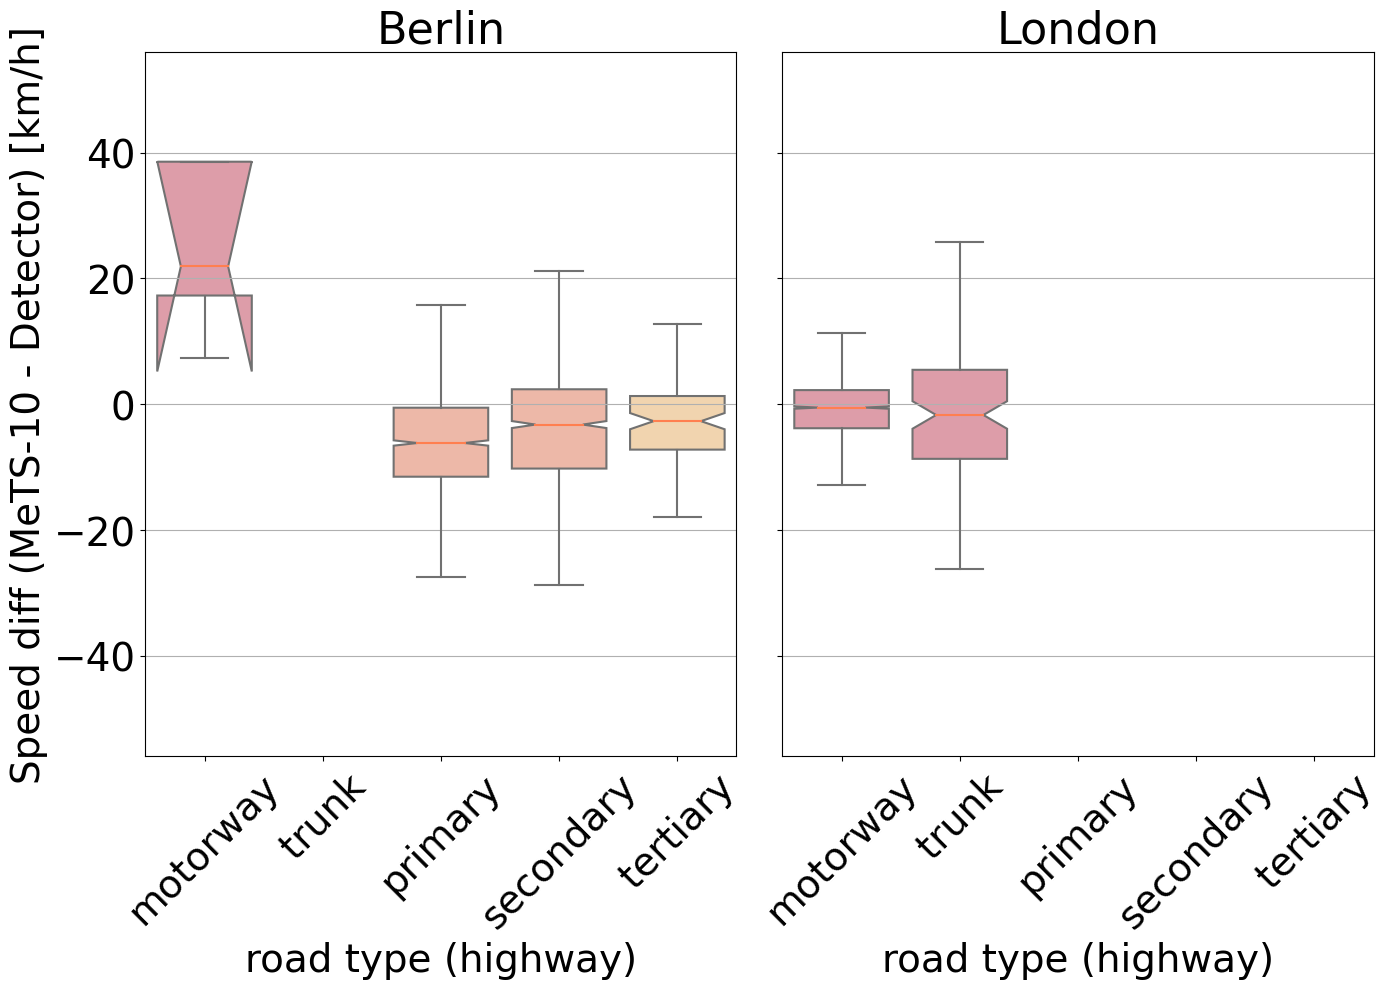

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(14, 10), tight_layout=True)
diff_boxplot(usm_berlin, axs[0], labelsize=28, city='Berlin')
diff_boxplot(usm_london, axs[1], labelsize=28, city='London')
axs[1].get_yaxis().set_ticklabels([])
axs[1].set_ylabel('')
# plt.savefig("counter_diff_boxplot_uber.png")
# plt.savefig("counter_diff_boxplot_uber.pdf")

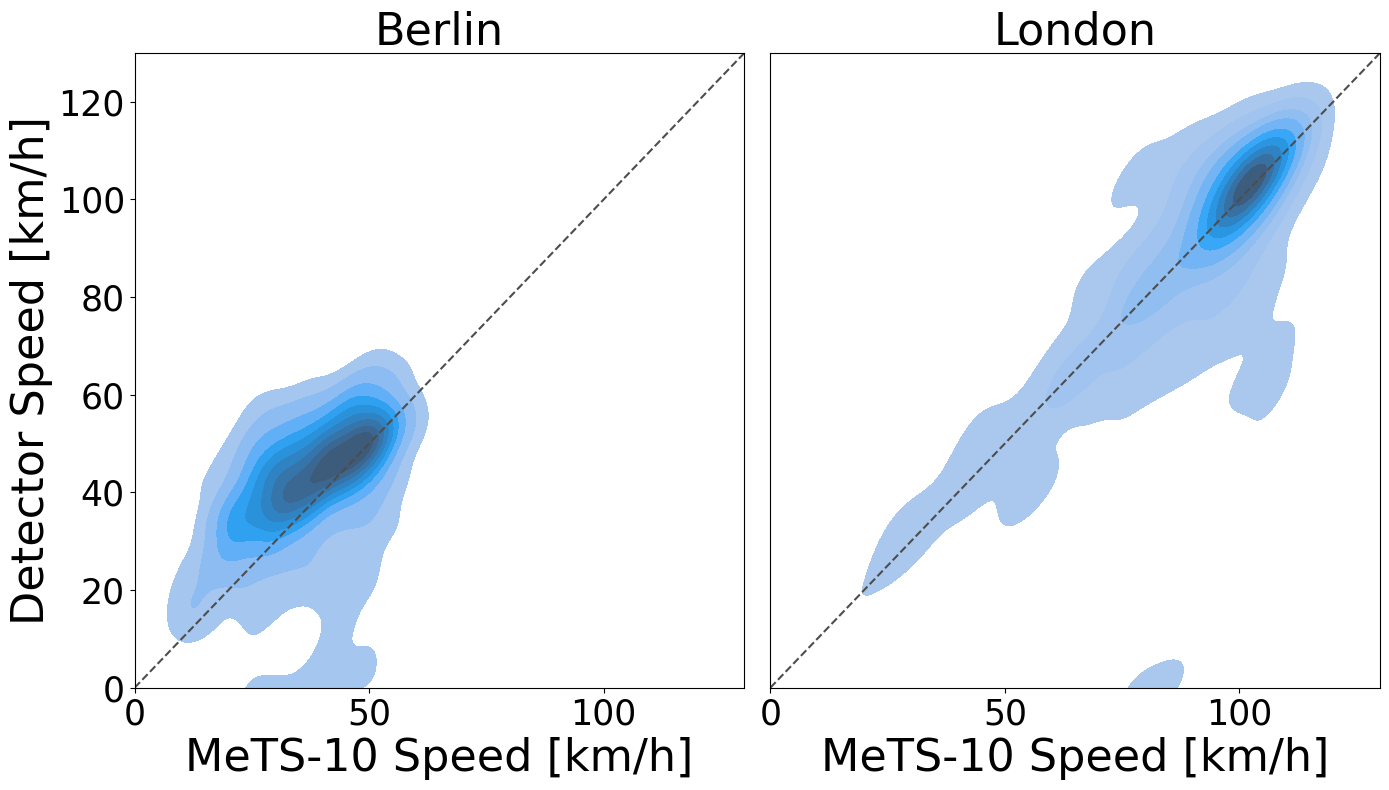

In [13]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(14,8))
plot_kde_scatter(usm_berlin, ax=axs[0], labelsize=25, titlesize=32, city='Berlin')
plot_kde_scatter(usm_london, ax=axs[1], labelsize=25, titlesize=32, city='London')
axs[1].get_yaxis().set_visible(False)
# plt.savefig("sxs_snsspeed_uber.png")
# plt.savefig("sxs_snsspeed_uber.pdf")

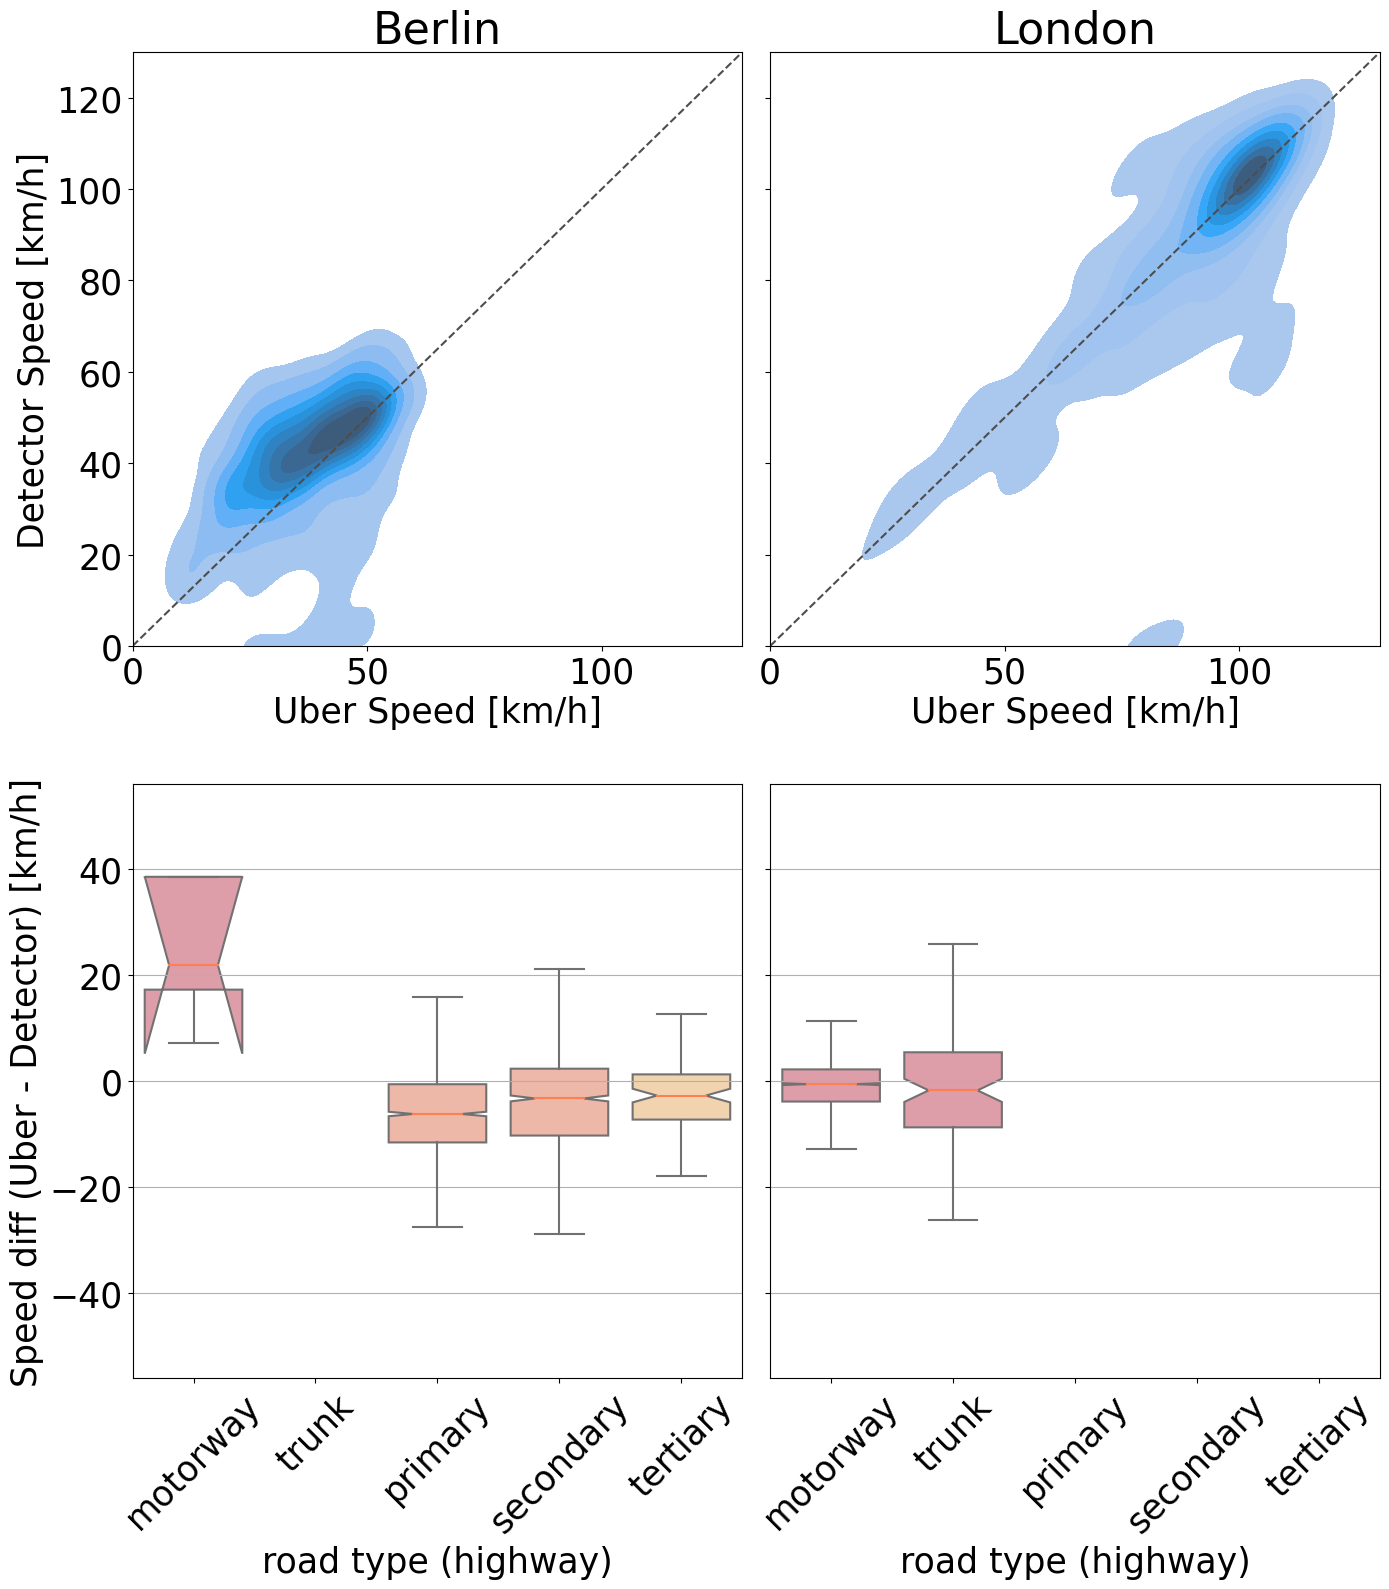

In [37]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(14,16))
plot_kde_scatter(usm_berlin, ax=axs[0][0], labelsize=25, titlesize=32, city='Berlin', x_label='Uber Speed [km/h]')
plot_kde_scatter(usm_london, ax=axs[0][1], labelsize=25, titlesize=32, city='London', x_label='Uber Speed [km/h]')
diff_boxplot(usm_berlin, axs[1][0], labelsize=25, city=' ', y_label='Speed diff (Uber - Detector) [km/h]')
diff_boxplot(usm_london, axs[1][1], labelsize=25, city=' ', y_label='Speed diff (Uber - Detector) [km/h]')
axs[0][1].get_yaxis().set_ticklabels([])
axs[1][1].get_yaxis().set_ticklabels([])
axs[0][1].set_ylabel('')
axs[1][1].set_ylabel('')
plt.savefig("plots/counter_uber_diff.png")
plt.savefig("plots/counter_uber_diff.pdf")

In [38]:
usm_berlin[usm_berlin['highway'] == 'motorway']

,id,u,v,gkey,hour,highway,speed_counter,speed_probes,year,month,day,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,speed_kph_mean,speed_kph_stddev,diff
0,100101010000167,268076575,1827856523,268076575_1827856523_150912137,8,motorway,80.3,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,7.393
1,100101010000268,268076575,1827856523,268076575_1827856523_150912137,8,motorway,3.0,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,84.693
2,100101010000369,268076575,1827856523,268076575_1827856523_150912137,8,motorway,64.4,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,23.293
3,100101010000470,268076575,1827856523,268076575_1827856523_150912137,8,motorway,67.0,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,20.693


In [39]:
usm_berlin[usm_berlin['highway'] == 'primary']

,id,u,v,gkey,hour,highway,speed_counter,speed_probes,year,month,day,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,speed_kph_mean,speed_kph_stddev,diff
4,100101010007948,311181577,311181586,311181577_311181586_377739469,8,primary,30.2,28.784314,2019,6,4,2019-06-04T06:00:00.000Z,68a21811316a702ccec8092adc35fd10419e5741,c37e260ef1b1cb44c2d57c9dad825cab968ace12,60c7ec0d9db8ddc206d636543efceef5181115b7,377739469,23.936,17.191,6.264
5,100101010008049,311181577,311181586,311181577_311181586_377739469,8,primary,34.2,28.784314,2019,6,4,2019-06-04T06:00:00.000Z,68a21811316a702ccec8092adc35fd10419e5741,c37e260ef1b1cb44c2d57c9dad825cab968ace12,60c7ec0d9db8ddc206d636543efceef5181115b7,377739469,23.936,17.191,10.264
6,100101010007948,311181577,311181586,311181577_311181586_377739469,9,primary,22.3,17.843137,2019,6,4,2019-06-04T07:00:00.000Z,68a21811316a702ccec8092adc35fd10419e5741,c37e260ef1b1cb44c2d57c9dad825cab968ace12,60c7ec0d9db8ddc206d636543efceef5181115b7,377739469,11.732,8.049,10.568
7,100101010008049,311181577,311181586,311181577_311181586_377739469,9,primary,26.6,17.843137,2019,6,4,2019-06-04T07:00:00.000Z,68a21811316a702ccec8092adc35fd10419e5741,c37e260ef1b1cb44c2d57c9dad825cab968ace12,60c7ec0d9db8ddc206d636543efceef5181115b7,377739469,11.732,8.049,14.868
8,100101010007948,311181577,311181586,311181577_311181586_377739469,13,primary,28.6,26.705882,2019,6,4,2019-06-04T11:00:00.000Z,68a21811316a702ccec8092adc35fd10419e5741,c37e260ef1b1cb44c2d57c9dad825cab968ace12,60c7ec0d9db8ddc206d636543efceef5181115b7,377739469,29.203,16.277,0.603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3021,100101010094137,20246260,162070833,20246260_162070833_25042039,21,primary,49.0,43.019608,2019,6,4,2019-06-04T19:00:00.000Z,56245f4c0d217f2c2ab5a1df1a152e98adba65ec,7ffbd1ef0bef7dd6086bb3b92dd88d6902ead972,bf28c3973c3515878674679bdf50e71ec892b2bf,25042039,39.883,6.642,9.117
3022,100101010094036,20246260,162070833,20246260_162070833_25042039,22,primary,39.5,36.450980,2019,6,4,2019-06-04T20:00:00.000Z,56245f4c0d217f2c2ab5a1df1a152e98adba65ec,7ffbd1ef0bef7dd6086bb3b92dd88d6902ead972,bf28c3973c3515878674679bdf50e71ec892b2bf,25042039,38.128,8.654,1.372
3023,100101010094137,20246260,162070833,20246260_162070833_25042039,22,primary,48.8,36.450980,2019,6,4,2019-06-04T20:00:00.000Z,56245f4c0d217f2c2ab5a1df1a152e98adba65ec,7ffbd1ef0bef7dd6086bb3b92dd88d6902ead972,bf28c3973c3515878674679bdf50e71ec892b2bf,25042039,38.128,8.654,10.672
3024,100101010094036,20246260,162070833,20246260_162070833_25042039,23,primary,40.5,43.176471,2019,6,4,2019-06-04T21:00:00.000Z,56245f4c0d217f2c2ab5a1df1a152e98adba65ec,7ffbd1ef0bef7dd6086bb3b92dd88d6902ead972,bf28c3973c3515878674679bdf50e71ec892b2bf,25042039,40.497,7.993,0.003


In [42]:
len(usm_berlin[usm_berlin['highway'] == 'primary']['id'].unique())

150

In [44]:
len(usm_berlin[usm_berlin['highway'] == 'secondary']['id'].unique())

146

In [5]:
len(usm_berlin['id'].unique())

318

In [6]:
len(usm_london['id'].unique())

195

In [7]:
usm_berlin

,id,u,v,gkey,hour,highway,speed_counter,speed_probes,year,month,day,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,speed_kph_mean,speed_kph_stddev,diff
0,100101010000167,268076575,1827856523,268076575_1827856523_150912137,8,motorway,80.3,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,7.393
1,100101010000268,268076575,1827856523,268076575_1827856523_150912137,8,motorway,3.0,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,84.693
2,100101010000369,268076575,1827856523,268076575_1827856523_150912137,8,motorway,64.4,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,23.293
3,100101010000470,268076575,1827856523,268076575_1827856523_150912137,8,motorway,67.0,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,20.693
4,100101010007948,311181577,311181586,311181577_311181586_377739469,8,primary,30.2,28.784314,2019,6,4,2019-06-04T06:00:00.000Z,68a21811316a702ccec8092adc35fd10419e5741,c37e260ef1b1cb44c2d57c9dad825cab968ace12,60c7ec0d9db8ddc206d636543efceef5181115b7,377739469,23.936,17.191,6.264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,100101010099793,26736176,26736175,26736176_26736175_31621007,9,secondary,39.1,21.549020,2019,6,4,2019-06-04T07:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,17.264,6.404,21.836
3032,100101010099692,26736176,26736175,26736176_26736175_31621007,13,secondary,37.1,22.029412,2019,6,4,2019-06-04T11:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,19.967,8.742,17.133
3033,100101010099793,26736176,26736175,26736176_26736175_31621007,13,secondary,42.5,22.029412,2019,6,4,2019-06-04T11:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,19.967,8.742,22.533
3034,100101010099692,26736176,26736175,26736176_26736175_31621007,16,secondary,35.3,21.588235,2019,6,4,2019-06-04T14:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,14.503,6.484,20.797


In [22]:
usm_berlin['diff'].mean()

10.861862318840581

In [23]:
usm_berlin['diff'].std()

10.659972132841867

In [15]:
usm_berlin[usm_berlin['highway'] == 'motorway']['diff'].mean()

34.018

In [16]:
usm_berlin[usm_berlin['highway'] == 'primary']['diff'].mean()

10.129118644067796

In [56]:
usm_berlin[usm_berlin['highway'] == 'secondary']['diff'].mean()

12.129481393507522

In [72]:
usm_berlin['counter_diff'] = (usm_berlin['speed_counter'] - usm_berlin['speed_probes']).abs()
usm_berlin['diffdiff'] = (usm_berlin['diff'] - usm_berlin['counter_diff'])
usm_berlin

,id,u,v,gkey,hour,highway,speed_counter,speed_probes,year,month,...,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,speed_kph_mean,speed_kph_stddev,diff,counter_diff,diffdiff
0,100101010000167,268076575,1827856523,268076575_1827856523_150912137,8,motorway,80.3,87.607843,2019,6,...,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,7.393,7.307843,0.085157
1,100101010000268,268076575,1827856523,268076575_1827856523_150912137,8,motorway,3.0,87.607843,2019,6,...,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,84.693,84.607843,0.085157
2,100101010000369,268076575,1827856523,268076575_1827856523_150912137,8,motorway,64.4,87.607843,2019,6,...,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,23.293,23.207843,0.085157
3,100101010000470,268076575,1827856523,268076575_1827856523_150912137,8,motorway,67.0,87.607843,2019,6,...,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,20.693,20.607843,0.085157
4,100101010007948,311181577,311181586,311181577_311181586_377739469,8,primary,30.2,28.784314,2019,6,...,2019-06-04T06:00:00.000Z,68a21811316a702ccec8092adc35fd10419e5741,c37e260ef1b1cb44c2d57c9dad825cab968ace12,60c7ec0d9db8ddc206d636543efceef5181115b7,377739469,23.936,17.191,6.264,1.415686,4.848314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,100101010099793,26736176,26736175,26736176_26736175_31621007,9,secondary,39.1,21.549020,2019,6,...,2019-06-04T07:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,17.264,6.404,21.836,17.550980,4.285020
3032,100101010099692,26736176,26736175,26736176_26736175_31621007,13,secondary,37.1,22.029412,2019,6,...,2019-06-04T11:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,19.967,8.742,17.133,15.070588,2.062412
3033,100101010099793,26736176,26736175,26736176_26736175_31621007,13,secondary,42.5,22.029412,2019,6,...,2019-06-04T11:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,19.967,8.742,22.533,20.470588,2.062412
3034,100101010099692,26736176,26736175,26736176_26736175_31621007,16,secondary,35.3,21.588235,2019,6,...,2019-06-04T14:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,14.503,6.484,20.797,13.711765,7.085235


In [71]:
usm_london['counter_diff'] = (usm_london['speed_counter'] - usm_london['speed_probes']).abs()
usm_london['diffdiff'] = (usm_london['diff'] - usm_london['counter_diff'])
usm_london

,id,u,v,gkey,hour,highway,speed_counter,speed_probes,year,month,...,segment_id,start_junction_id,end_junction_id,osmid,speed_mph_mean,speed_mph_stddev,speed_kph_mean,diff,counter_diff,diffdiff
0,10054,104439,1199441658,104439_1199441658_22633662,1,motorway,101.388420,115.764706,2020,1,...,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,59.439,6.054,95.657560,5.730860,14.376286,-8.645426
1,10054,104439,1199441658,104439_1199441658_22633662,2,motorway,99.779080,91.764706,2020,1,...,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,59.987,6.692,96.539479,3.239601,8.014374,-4.774773
2,10054,104439,1199441658,104439_1199441658_22633662,3,motorway,101.388420,94.823529,2020,1,...,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,60.402,7.190,97.207355,4.181065,6.564891,-2.383825
3,10054,104439,1199441658,104439_1199441658_22633662,4,motorway,102.997760,97.411765,2020,1,...,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,62.740,6.939,100.969992,2.027768,5.585995,-3.558227
4,10054,104439,1199441658,104439_1199441658_22633662,5,motorway,102.997760,98.352941,2020,1,...,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,61.633,5.962,99.188452,3.809308,4.644819,-0.835511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945,9928,200284,104439,200284_104439_22632032,17,motorway_link,74.834310,85.578431,2020,1,...,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,46.705,7.676,75.164225,0.329915,10.744121,-10.414207
2946,9928,200284,104439,200284_104439_22632032,19,motorway_link,78.052990,81.382353,2020,1,...,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,48.442,5.869,77.959648,0.093342,3.329363,-3.236021
2947,9928,200284,104439,200284_104439_22632032,21,motorway_link,82.076340,78.823529,2020,1,...,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,52.963,6.228,85.235474,3.159134,3.252811,-0.093676
2948,9928,200284,104439,200284_104439_22632032,22,motorway_link,82.478675,94.029412,2020,1,...,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,48.132,5.650,77.460753,5.017922,11.550737,-6.532815


In [18]:
HIGHWAY_ORDER = ['motorway', 'motorway_link', 'trunk', 'trunk_link', 'primary', 'secondary', 'tertiary', 'residential', 'unclassified']
HIGHWAY_SORTER = lambda hws: [HIGHWAY_ORDER.index(hw) for hw in hws]

def diff_stats(df):
    df["diff_uber"] = df['speed_kph_mean'] - df['speed_counter']
    df["diff_mets"] = df['speed_probes'] - df['speed_counter']
    df["diffdiff"] = df['diff_uber'] - df['diff_mets']
    df = df[['highway', 'diffdiff']]
    rdf = df.groupby('highway').agg(
        diff_mean=('diffdiff', 'mean'), diff_std=('diffdiff', 'std'), diff_median=('diffdiff', 'median'),
#         q3=('diffdiff', lambda x: x.quantile(q=0.03)),
        diff_iqr25=('diffdiff', lambda x: x.quantile(q=0.25)),
#         q50=('diffdiff', lambda x: x.quantile(q=0.5)),
        diff_iqr75=('diffdiff', lambda x: x.quantile(q=0.75)),
#         q97=('diffdiff', lambda x: x.quantile(q=0.97)),
        value_count=('diffdiff', 'count')
    ).sort_values('highway', key=HIGHWAY_SORTER).reset_index()
    df['highway'] = 'TOTAL'
    tdf = df.groupby('highway').agg(
        diff_mean=('diffdiff', 'mean'), diff_std=('diffdiff', 'std'), diff_median=('diffdiff', 'median'),
#         q3=('diffdiff', lambda x: x.quantile(q=0.03)),
        diff_iqr25=('diffdiff', lambda x: x.quantile(q=0.25)),
#         q50=('diffdiff', lambda x: x.quantile(q=0.5)),
        diff_iqr75=('diffdiff', lambda x: x.quantile(q=0.75)),
#         q97=('diffdiff', lambda x: x.quantile(q=0.97)),
        value_count=('diffdiff', 'count')
    ).reset_index()
    rdf = rdf.append(tdf, ignore_index=True)
    return rdf
    
diff_stats_berlin = diff_stats(usm_berlin).style.set_caption("Berlin (CounterDiff Uber - CounterDiff MeTS-10)")
diff_stats_berlin

/var/folders/zg/l5sgc79n5h508n79m815wzdw0000gn/T/ipykernel_86257/3483004422.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['highway'] = 'TOTAL'
/var/folders/zg/l5sgc79n5h508n79m815wzdw0000gn/T/ipykernel_86257/3483004422.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rdf = rdf.append(tdf, ignore_index=True)


,highway,diff_mean,diff_std,diff_median,diff_iqr25,diff_iqr75,value_count
0,motorway,0.085157,0.000000,0.085157,0.085157,0.085157,4
1,primary,-0.308754,7.130017,0.070118,-3.890407,4.114201,1652
2,secondary,-1.618418,6.557045,-0.834039,-5.488941,2.443412,1263
3,tertiary,0.348630,4.293856,0.087137,-2.174368,2.750127,108
4,residential,2.179791,2.232771,1.895882,1.070020,2.661529,9
5,TOTAL,-0.822303,6.832255,-0.212961,-4.411338,3.321373,3036


In [19]:
diff_stats_berlin.to_latex()

'\\begin{table}\n\\caption{Berlin (CounterDiff Uber - CounterDiff MeTS-10)}\n\\begin{tabular}{llrrrrrr}\n & highway & diff_mean & diff_std & diff_median & diff_iqr25 & diff_iqr75 & value_count \\\\\n0 & motorway & 0.085157 & 0.000000 & 0.085157 & 0.085157 & 0.085157 & 4 \\\\\n1 & primary & -0.308754 & 7.130017 & 0.070118 & -3.890407 & 4.114201 & 1652 \\\\\n2 & secondary & -1.618418 & 6.557045 & -0.834039 & -5.488941 & 2.443412 & 1263 \\\\\n3 & tertiary & 0.348630 & 4.293856 & 0.087137 & -2.174368 & 2.750127 & 108 \\\\\n4 & residential & 2.179791 & 2.232771 & 1.895882 & 1.070020 & 2.661529 & 9 \\\\\n5 & TOTAL & -0.822303 & 6.832255 & -0.212961 & -4.411338 & 3.321373 & 3036 \\\\\n\\end{tabular}\n\\end{table}\n'

In [5]:
usm_berlin_onemonth = pd.read_parquet(DATA_PATH / 'berlin' / 'speeds_merged_uber_berlin_201906.parquet')
usm_berlin_onemonth

,id,u,v,gkey,date,hour,highway,speed_counter,speed_probes,day,year,month,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,speed_kph_mean,speed_kph_stddev,diff
0,100101010000167,268076575,1827856523,268076575_1827856523_150912137,2019-06-04,8,motorway,80.3,87.607843,4,2019,6,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,7.393
1,100101010000268,268076575,1827856523,268076575_1827856523_150912137,2019-06-04,8,motorway,3.0,87.607843,4,2019,6,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,84.693
2,100101010000369,268076575,1827856523,268076575_1827856523_150912137,2019-06-04,8,motorway,64.4,87.607843,4,2019,6,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,23.293
3,100101010000470,268076575,1827856523,268076575_1827856523_150912137,2019-06-04,8,motorway,67.0,87.607843,4,2019,6,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,20.693
4,100101010000167,268076575,1827856523,268076575_1827856523_150912137,2019-06-16,0,motorway,70.5,81.784314,16,2019,6,2019-06-15T22:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,81.420,6.677,10.920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122298,100101010099995,26736157,791127364,26736157_791127364_327805903,2019-06-29,0,secondary,44.3,40.852941,29,2019,6,2019-06-28T22:00:00.000Z,f72abe98ebf20fc76727855d1c714a02c9e831a1,7ee493c59fed5377ae1d1afe38ac7e9c91403f34,5b901c6260c4033646e53a147a8fb1ad09afa6a1,327805903,45.295,2.772,0.995
122299,100101010099894,26736157,791127364,26736157_791127364_327805903,2019-06-29,19,secondary,40.7,22.039216,29,2019,6,2019-06-29T17:00:00.000Z,f72abe98ebf20fc76727855d1c714a02c9e831a1,7ee493c59fed5377ae1d1afe38ac7e9c91403f34,5b901c6260c4033646e53a147a8fb1ad09afa6a1,327805903,42.013,3.030,1.313
122300,100101010099995,26736157,791127364,26736157_791127364_327805903,2019-06-29,19,secondary,41.2,22.039216,29,2019,6,2019-06-29T17:00:00.000Z,f72abe98ebf20fc76727855d1c714a02c9e831a1,7ee493c59fed5377ae1d1afe38ac7e9c91403f34,5b901c6260c4033646e53a147a8fb1ad09afa6a1,327805903,42.013,3.030,0.813
122301,100101010099894,26736157,791127364,26736157_791127364_327805903,2019-06-30,0,secondary,39.5,34.039216,30,2019,6,2019-06-29T22:00:00.000Z,f72abe98ebf20fc76727855d1c714a02c9e831a1,7ee493c59fed5377ae1d1afe38ac7e9c91403f34,5b901c6260c4033646e53a147a8fb1ad09afa6a1,327805903,43.395,4.157,3.895


In [84]:
# Filtering errorneous counter readings on highways
usm_berlin_onemonth = usm_berlin_onemonth[~((usm_berlin_onemonth['highway'] == 'motorway') & (usm_berlin_onemonth['speed_counter'] <= 3.0))]
usm_berlin_onemonth

,id,u,v,gkey,date,hour,highway,speed_counter,speed_probes,day,...,segment_id,start_junction_id,end_junction_id,osmid,speed_kph_mean,speed_kph_stddev,diff,diff_uber,diff_mets,diffdiff
0,100101010000167,268076575,1827856523,268076575_1827856523_150912137,2019-06-04,8,motorway,80.3,87.607843,4,...,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,7.393,7.393,7.307843,0.085157
2,100101010000369,268076575,1827856523,268076575_1827856523_150912137,2019-06-04,8,motorway,64.4,87.607843,4,...,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,23.293,23.293,23.207843,0.085157
3,100101010000470,268076575,1827856523,268076575_1827856523_150912137,2019-06-04,8,motorway,67.0,87.607843,4,...,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,20.693,20.693,20.607843,0.085157
4,100101010000167,268076575,1827856523,268076575_1827856523_150912137,2019-06-16,0,motorway,70.5,81.784314,16,...,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,81.420,6.677,10.920,10.920,11.284314,-0.364314
6,100101010000369,268076575,1827856523,268076575_1827856523_150912137,2019-06-16,0,motorway,81.1,81.784314,16,...,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,81.420,6.677,0.320,0.320,0.684314,-0.364314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122298,100101010099995,26736157,791127364,26736157_791127364_327805903,2019-06-29,0,secondary,44.3,40.852941,29,...,f72abe98ebf20fc76727855d1c714a02c9e831a1,7ee493c59fed5377ae1d1afe38ac7e9c91403f34,5b901c6260c4033646e53a147a8fb1ad09afa6a1,327805903,45.295,2.772,0.995,0.995,-3.447059,4.442059
122299,100101010099894,26736157,791127364,26736157_791127364_327805903,2019-06-29,19,secondary,40.7,22.039216,29,...,f72abe98ebf20fc76727855d1c714a02c9e831a1,7ee493c59fed5377ae1d1afe38ac7e9c91403f34,5b901c6260c4033646e53a147a8fb1ad09afa6a1,327805903,42.013,3.030,1.313,1.313,-18.660784,19.973784
122300,100101010099995,26736157,791127364,26736157_791127364_327805903,2019-06-29,19,secondary,41.2,22.039216,29,...,f72abe98ebf20fc76727855d1c714a02c9e831a1,7ee493c59fed5377ae1d1afe38ac7e9c91403f34,5b901c6260c4033646e53a147a8fb1ad09afa6a1,327805903,42.013,3.030,0.813,0.813,-19.160784,19.973784
122301,100101010099894,26736157,791127364,26736157_791127364_327805903,2019-06-30,0,secondary,39.5,34.039216,30,...,f72abe98ebf20fc76727855d1c714a02c9e831a1,7ee493c59fed5377ae1d1afe38ac7e9c91403f34,5b901c6260c4033646e53a147a8fb1ad09afa6a1,327805903,43.395,4.157,3.895,3.895,-5.460784,9.355784


In [85]:
diff_stats_berlin_onemonth = diff_stats(usm_berlin_onemonth).style.set_caption("Berlin 30 days (CounterDiff Uber - CounterDiff MeTS-10)")
diff_stats_berlin_onemonth

/var/folders/zg/l5sgc79n5h508n79m815wzdw0000gn/T/ipykernel_86257/3483004422.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff_uber"] = df['speed_kph_mean'] - df['speed_counter']
/var/folders/zg/l5sgc79n5h508n79m815wzdw0000gn/T/ipykernel_86257/3483004422.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff_mets"] = df['speed_probes'] - df['speed_counter']
/var/folders/zg/l5sgc79n5h508n79m815wzdw0000gn/T/ipykernel_86257/3483004422.py:7: SettingWithCopyWarning: 
A value is trying to be set o

,highway,diff_mean,diff_std,diff_median,diff_iqr25,diff_iqr75,value_count
0,motorway,0.796400,5.414309,-0.223706,-1.050098,0.616196,30
1,primary,0.526235,6.378054,0.787451,-2.769275,4.275824,69214
2,secondary,-0.123400,6.207306,0.194863,-3.348167,3.542725,49526
3,tertiary,-0.051480,5.857588,-0.034078,-3.111358,3.052417,3466
4,residential,2.922622,4.547528,2.402353,0.312111,5.296824,57
5,TOTAL,0.247957,6.302485,0.503647,-3.010000,3.932196,122293


In [122]:
# def diff_hists(df):
#     df["diff_uber"] = df['speed_kph_mean'] - df['speed_counter']
#     df["diff_mets"] = df['speed_probes'] - df['speed_counter']
#     df["diffdiff"] = df['diff_uber'] - df['diff_mets']
#     df["diffdiff"].hist(bins=50)
    
# diff_hists(usm_berlin_onemonth)

In [87]:
diff_stats_london = diff_stats(usm_london).style.set_caption("London (CounterDiff Uber - CounterDiff MeTS-10)")
diff_stats_london

/var/folders/zg/l5sgc79n5h508n79m815wzdw0000gn/T/ipykernel_86257/3483004422.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['highway'] = 'TOTAL'
/var/folders/zg/l5sgc79n5h508n79m815wzdw0000gn/T/ipykernel_86257/3483004422.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rdf = rdf.append(tdf, ignore_index=True)


,highway,diff_mean,diff_std,diff_median,diff_iqr25,diff_iqr75,value_count
0,motorway,2.896026,6.366784,2.451195,-0.964571,5.997375,2679
1,motorway_link,-18.401719,15.545275,-15.267185,-28.780917,-7.726829,153
2,trunk,3.713743,10.272624,1.941807,-2.067089,8.528273,103
3,trunk_link,-28.699484,11.187563,-28.091592,-37.506729,-22.810476,15
4,TOTAL,1.659326,8.978592,2.026496,-1.715875,5.827346,2950


In [23]:
usm_london_onemonth = pd.read_parquet(DATA_PATH / 'london' / 'speeds_merged_uber_london_202001.parquet')
usm_london_onemonth

,id,u,v,gkey,date,hour,highway,speed_counter,speed_probes,day,...,month,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,speed_mph_mean,speed_mph_stddev,speed_kph_mean,diff
0,10054,104439,1199441658,104439_1199441658_22633662,2020-01-01,0,motorway,105.814105,98.352941,1,...,1,2020-01-01T00:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,64.122,6.953,103.194099,2.620006
1,10054,104439,1199441658,104439_1199441658_22633662,2020-01-01,1,motorway,102.193090,98.117647,1,...,1,2020-01-01T01:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,60.117,7.525,96.748693,5.444397
2,10054,104439,1199441658,104439_1199441658_22633662,2020-01-01,2,motorway,103.802430,99.352941,1,...,1,2020-01-01T02:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,61.874,7.611,99.576303,4.226127
3,10054,104439,1199441658,104439_1199441658_22633662,2020-01-01,4,motorway,104.204765,91.647059,1,...,1,2020-01-01T04:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,62.691,6.874,100.891134,3.313631
4,10054,104439,1199441658,104439_1199441658_22633662,2020-01-01,5,motorway,101.790755,94.666667,1,...,1,2020-01-01T05:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,61.744,7.629,99.367089,2.423666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56220,9928,200284,104439,200284_104439_22632032,2020-01-31,17,motorway_link,76.041315,69.823529,31,...,1,2020-01-31T17:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,44.548,3.979,71.692878,4.348437
56221,9928,200284,104439,200284_104439_22632032,2020-01-31,18,motorway_link,76.845985,91.852941,31,...,1,2020-01-31T18:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,45.414,3.301,73.086567,3.759418
56222,9928,200284,104439,200284_104439_22632032,2020-01-31,19,motorway_link,78.455325,84.264706,31,...,1,2020-01-31T19:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,46.374,2.491,74.631533,3.823792
56223,9928,200284,104439,200284_104439_22632032,2020-01-31,21,motorway_link,81.674005,103.686275,31,...,1,2020-01-31T21:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,48.220,8.237,77.602375,4.071630


In [94]:
diff_stats_london_onemonth = diff_stats(usm_london_onemonth).style.set_caption("London 30 days (CounterDiff Uber - CounterDiff MeTS-10)")
diff_stats_london_onemonth

/var/folders/zg/l5sgc79n5h508n79m815wzdw0000gn/T/ipykernel_86257/3483004422.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['highway'] = 'TOTAL'
/var/folders/zg/l5sgc79n5h508n79m815wzdw0000gn/T/ipykernel_86257/3483004422.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rdf = rdf.append(tdf, ignore_index=True)


,highway,diff_mean,diff_std,diff_median,diff_iqr25,diff_iqr75,value_count
0,motorway,3.056858,6.926557,2.273585,-1.131806,6.270245,50777
1,motorway_link,-18.300085,15.978163,-16.496598,-28.037813,-7.535295,3275
2,trunk,3.906163,11.074098,2.583295,-2.276377,10.516522,1834
3,trunk_link,-27.639927,12.654695,-27.497865,-35.920756,-20.148491,339
4,TOTAL,1.655479,9.667750,1.873293,-1.888289,6.062858,56225


In [123]:
# diff_hists(usm_london_onemonth)

# Final revision: new plots for supplement C

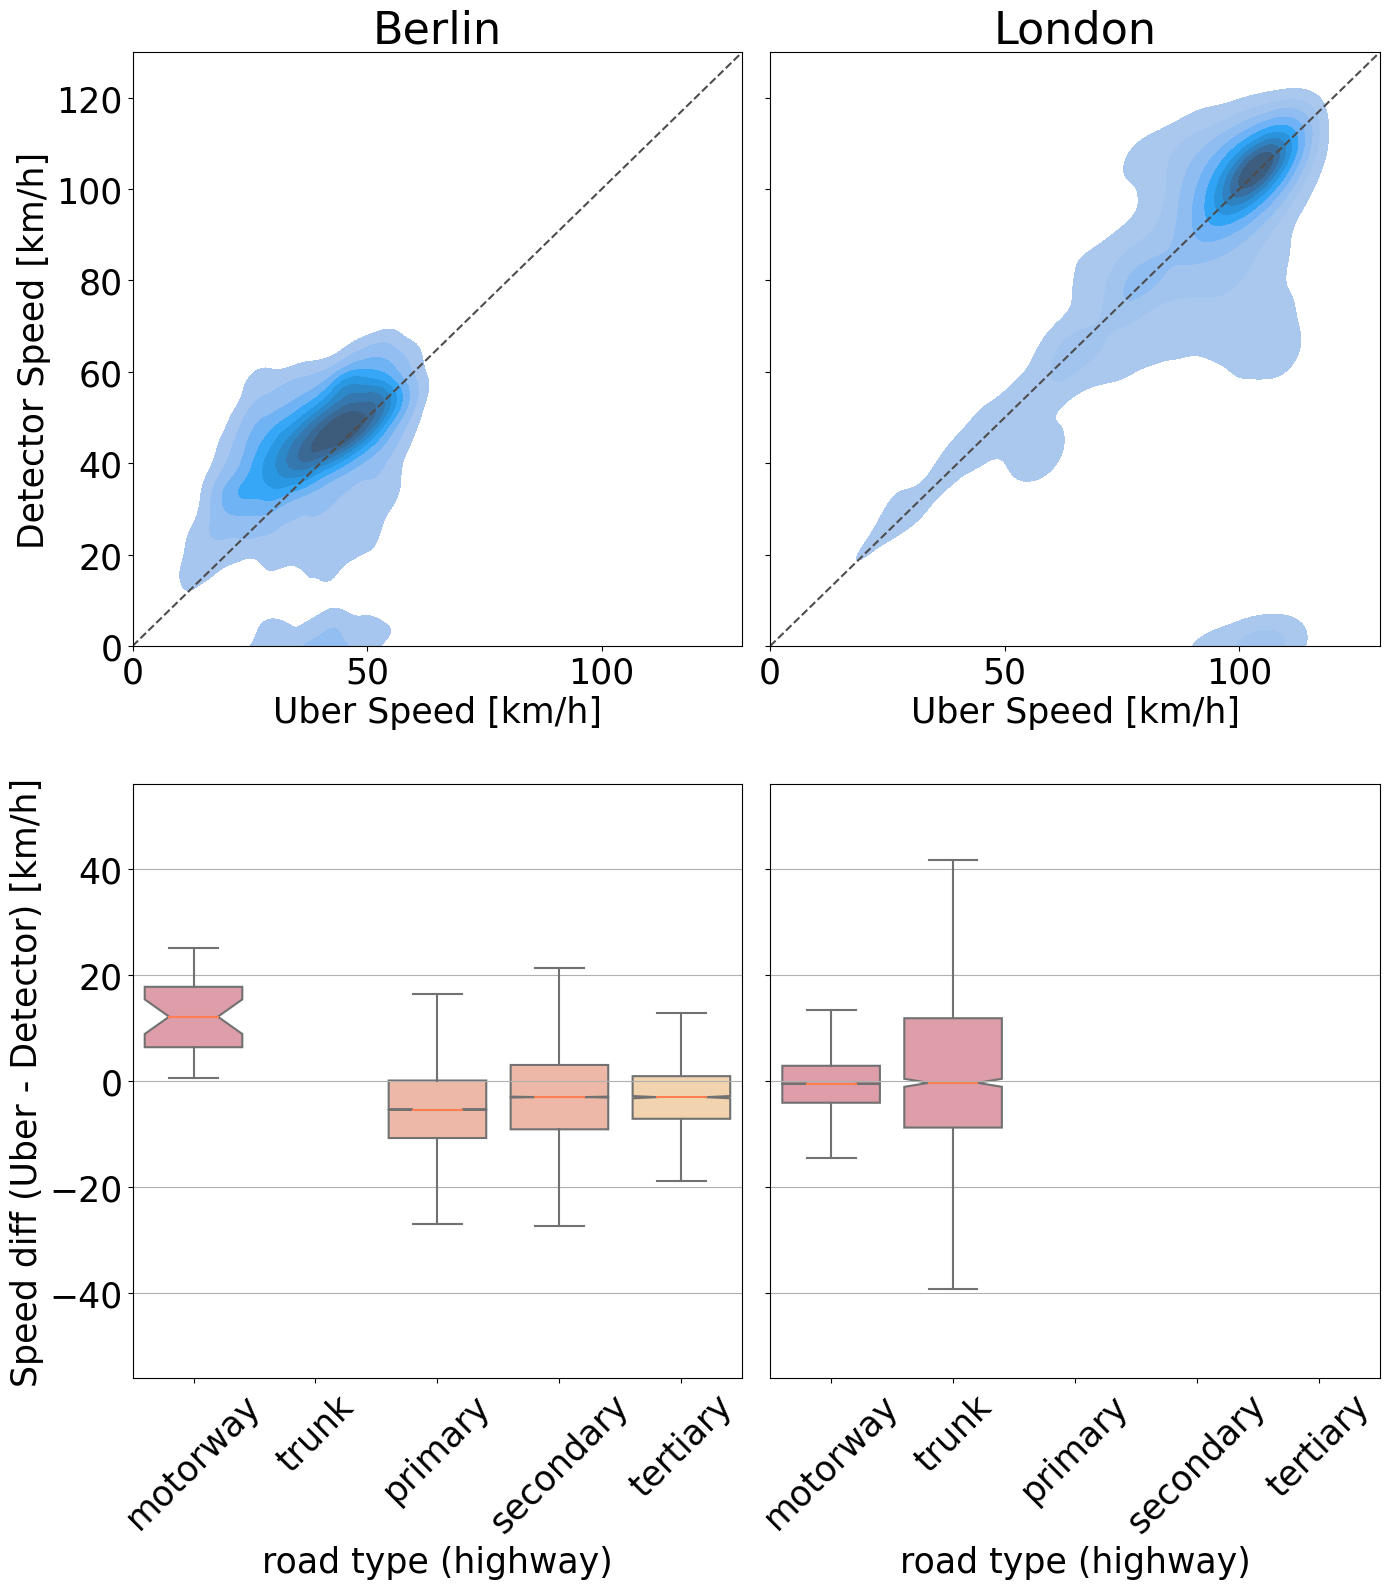

In [116]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(14,16))
plot_kde_scatter(usm_berlin_onemonth, ax=axs[0][0], labelsize=25, titlesize=32, city='Berlin', x_label='Uber Speed [km/h]')
plot_kde_scatter(usm_london_onemonth, ax=axs[0][1], labelsize=25, titlesize=32, city='London', x_label='Uber Speed [km/h]')
diff_boxplot(usm_berlin_onemonth, axs[1][0], labelsize=25, city=' ', y_label='Speed diff (Uber - Detector) [km/h]')
diff_boxplot(usm_london_onemonth, axs[1][1], labelsize=25, city=' ', y_label='Speed diff (Uber - Detector) [km/h]')
axs[0][1].get_yaxis().set_ticklabels([])
axs[1][1].get_yaxis().set_ticklabels([])
axs[0][1].set_ylabel('')
axs[1][1].set_ylabel('')
plt.savefig("plots/counter_uber_diff_onemonth.png")
plt.savefig("plots/counter_uber_diff_onemonth.pdf")

In [70]:
cm_berlin_onemonth = pd.read_parquet(DATA_PATH / 'berlin' / 'speeds_merged_berlin_201906.parquet')
cm_berlin_onemonth

,id,day,h,speed_counter,volume_x,way,u,v,gkey,osmid_x,volume_y,speed_probes,diff,osmid_y,highway
0,100101010000167,2019-06-01,0,82.8,227,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,91.0,86.274510,3.474510,150912137,motorway
1,100101010000167,2019-06-01,0,82.8,227,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,50.0,96.627451,13.827451,150912137,motorway
2,100101010000167,2019-06-01,0,82.8,227,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,43.0,84.705882,1.905882,150912137,motorway
3,100101010000167,2019-06-01,0,82.8,227,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,77.0,78.274510,4.525490,150912137,motorway
4,100101010000268,2019-06-01,0,3.0,43,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,91.0,86.274510,83.274510,150912137,motorway
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197538,100101010099995,2019-06-30,22,43.2,158,327805903,26736157,791127364,26736157_791127364_327805903,327805903,33.0,43.764706,0.564706,327805903,secondary
1197539,100101010099894,2019-06-30,23,40.4,113,327805903,26736157,791127364,26736157_791127364_327805903,327805903,52.0,43.529412,3.129412,327805903,secondary
1197540,100101010099894,2019-06-30,23,40.4,113,327805903,26736157,791127364,26736157_791127364_327805903,327805903,36.0,46.823529,6.423529,327805903,secondary
1197541,100101010099995,2019-06-30,23,43.5,121,327805903,26736157,791127364,26736157_791127364_327805903,327805903,52.0,43.529412,0.029412,327805903,secondary


In [73]:
# Filtering errorneous counter readings on highways
cm_berlin_onemonth = cm_berlin_onemonth[~((cm_berlin_onemonth['highway'] == 'motorway') & (cm_berlin_onemonth['speed_counter'] <= 3.0))]
cm_berlin_onemonth

,id,day,h,speed_counter,volume_x,way,u,v,gkey,osmid_x,volume_y,speed_probes,diff,osmid_y,highway
0,100101010000167,2019-06-01,0,82.8,227,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,91.0,86.274510,3.474510,150912137,motorway
1,100101010000167,2019-06-01,0,82.8,227,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,50.0,96.627451,13.827451,150912137,motorway
2,100101010000167,2019-06-01,0,82.8,227,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,43.0,84.705882,1.905882,150912137,motorway
3,100101010000167,2019-06-01,0,82.8,227,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,77.0,78.274510,4.525490,150912137,motorway
8,100101010000369,2019-06-01,0,80.2,303,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,91.0,86.274510,6.074510,150912137,motorway
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197538,100101010099995,2019-06-30,22,43.2,158,327805903,26736157,791127364,26736157_791127364_327805903,327805903,33.0,43.764706,0.564706,327805903,secondary
1197539,100101010099894,2019-06-30,23,40.4,113,327805903,26736157,791127364,26736157_791127364_327805903,327805903,52.0,43.529412,3.129412,327805903,secondary
1197540,100101010099894,2019-06-30,23,40.4,113,327805903,26736157,791127364,26736157_791127364_327805903,327805903,36.0,46.823529,6.423529,327805903,secondary
1197541,100101010099995,2019-06-30,23,43.5,121,327805903,26736157,791127364,26736157_791127364_327805903,327805903,52.0,43.529412,0.029412,327805903,secondary


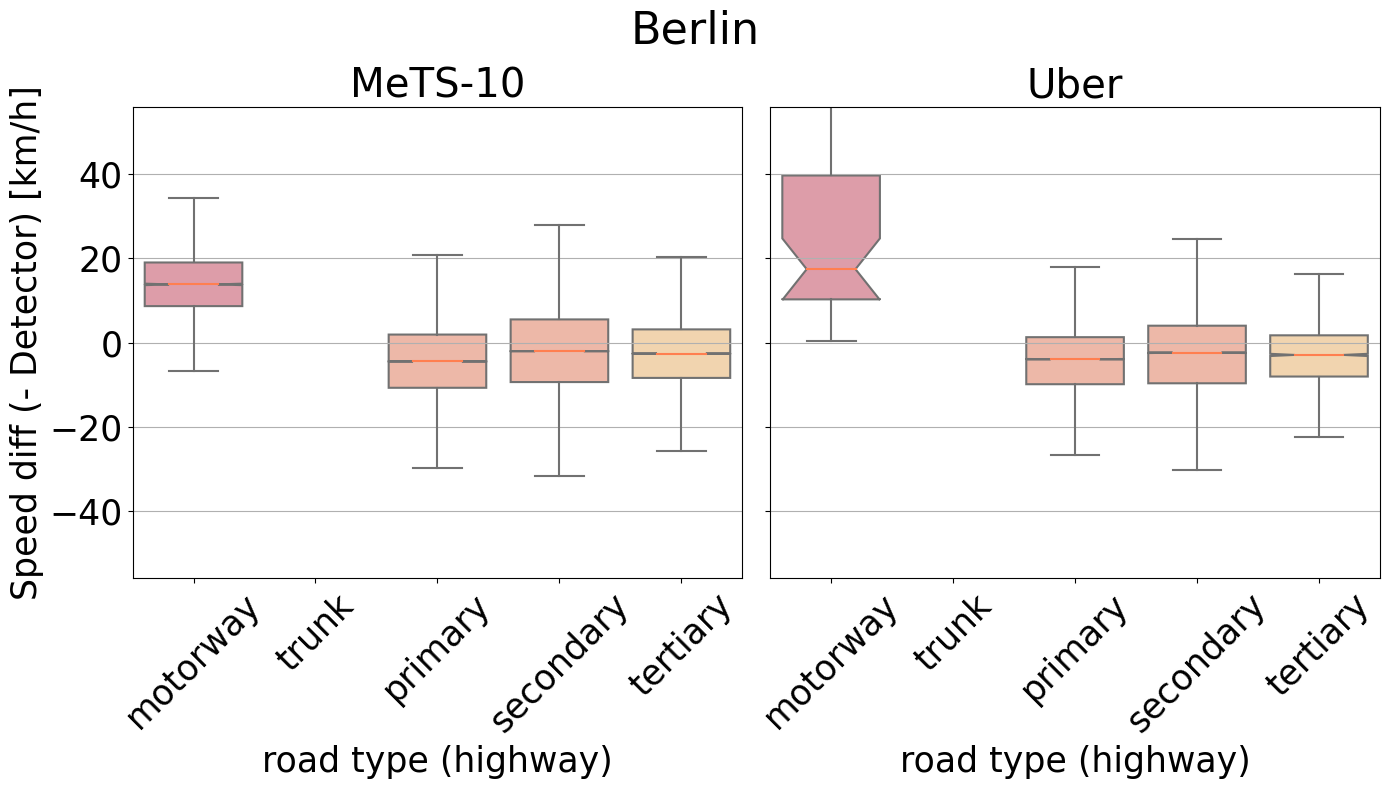

In [80]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(14,8))
diff_boxplot(cm_berlin_onemonth, axs[0], labelsize=25, city='MeTS-10', y_label='Speed diff (- Detector) [km/h]', speed_field='speed_probes')
diff_boxplot(usm_berlin_onemonth, axs[1], labelsize=25, city='Uber', y_label='Speed diff (- Detector) [km/h]', speed_field='speed_kph_mean')
axs[1].get_yaxis().set_ticklabels([])
axs[1].set_ylabel('')
fig.suptitle('Berlin', fontsize=32)
plt.savefig("plots/counter_diffs_sxs_berlin_onemonth.png")
plt.savefig("plots/counter_diffs_sxs_berlin_onemonth.pdf")

In [92]:
diff_stats_berlin_onemonth

,highway,diff_mean,diff_std,diff_median,diff_iqr25,diff_iqr75,value_count
0,motorway,0.796400,5.414309,-0.223706,-1.050098,0.616196,30
1,primary,0.526235,6.378054,0.787451,-2.769275,4.275824,69214
2,secondary,-0.123400,6.207306,0.194863,-3.348167,3.542725,49526
3,tertiary,-0.051480,5.857588,-0.034078,-3.111358,3.052417,3466
4,residential,2.922622,4.547528,2.402353,0.312111,5.296824,57
5,TOTAL,0.247957,6.302485,0.503647,-3.010000,3.932196,122293


In [117]:
print(diff_stats_berlin_onemonth.to_latex())

\begin{table}
\caption{Berlin 30 days (CounterDiff Uber - CounterDiff MeTS-10)}
\begin{tabular}{llrrrrrr}
 & highway & diff_mean & diff_std & diff_median & diff_iqr25 & diff_iqr75 & value_count \\
0 & motorway & 0.796400 & 5.414309 & -0.223706 & -1.050098 & 0.616196 & 30 \\
1 & primary & 0.526235 & 6.378054 & 0.787451 & -2.769275 & 4.275824 & 69214 \\
2 & secondary & -0.123400 & 6.207306 & 0.194863 & -3.348167 & 3.542725 & 49526 \\
3 & tertiary & -0.051480 & 5.857588 & -0.034078 & -3.111358 & 3.052417 & 3466 \\
4 & residential & 2.922622 & 4.547528 & 2.402353 & 0.312111 & 5.296824 & 57 \\
5 & TOTAL & 0.247957 & 6.302485 & 0.503647 & -3.010000 & 3.932196 & 122293 \\
\end{tabular}
\end{table}



In [49]:
cm_london_onemonth = pd.read_parquet(DATA_PATH / 'london' / 'speeds_merged_london_202001.parquet')
cm_london_onemonth

,id,name,lat,lon,heading,time_bin,volume_x,speed_counter,t,day,...,u,v,h,gkey,osmid_x,volume_y,speed_probes,diff,osmid_y,highway
0,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:15,36,98.16974,0,2020-01-01,...,12079091,202953,0,12079091_202953_2714200,2714200,2.0,90.352941,7.816799,2714200,motorway
1,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:15,36,98.16974,0,2020-01-01,...,12079091,202953,0,12079091_202953_2714200,2714200,3.0,92.705882,5.463858,2714200,motorway
2,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:15,36,98.16974,0,2020-01-01,...,12079091,202953,0,12079091_202953_2714200,2714200,10.0,110.588235,12.418495,2714200,motorway
3,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:30,52,101.38842,1,2020-01-01,...,12079091,202953,0,12079091_202953_2714200,2714200,2.0,90.352941,11.035479,2714200,motorway
4,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:30,52,101.38842,1,2020-01-01,...,12079091,202953,0,12079091_202953_2714200,2714200,3.0,92.705882,8.682538,2714200,motorway
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289637,10566,M25/5554B,51.688038,0.066105,-1,2020-01-31 23:45,193,104.60710,94,2020-01-31,...,27461215,197771,23,27461215_197771_4546652,4546652,6.0,104.000000,0.607100,4546652,motorway
1289638,10566,M25/5554B,51.688038,0.066105,-1,2020-02-01 00:00,152,104.60710,95,2020-01-31,...,27461215,197771,23,27461215_197771_4546652,4546652,4.0,101.647059,2.960041,4546652,motorway
1289639,10566,M25/5554B,51.688038,0.066105,-1,2020-02-01 00:00,152,104.60710,95,2020-01-31,...,27461215,197771,23,27461215_197771_4546652,4546652,1.0,104.941176,0.334076,4546652,motorway
1289640,10566,M25/5554B,51.688038,0.066105,-1,2020-02-01 00:00,152,104.60710,95,2020-01-31,...,27461215,197771,23,27461215_197771_4546652,4546652,3.0,89.882353,14.724747,4546652,motorway


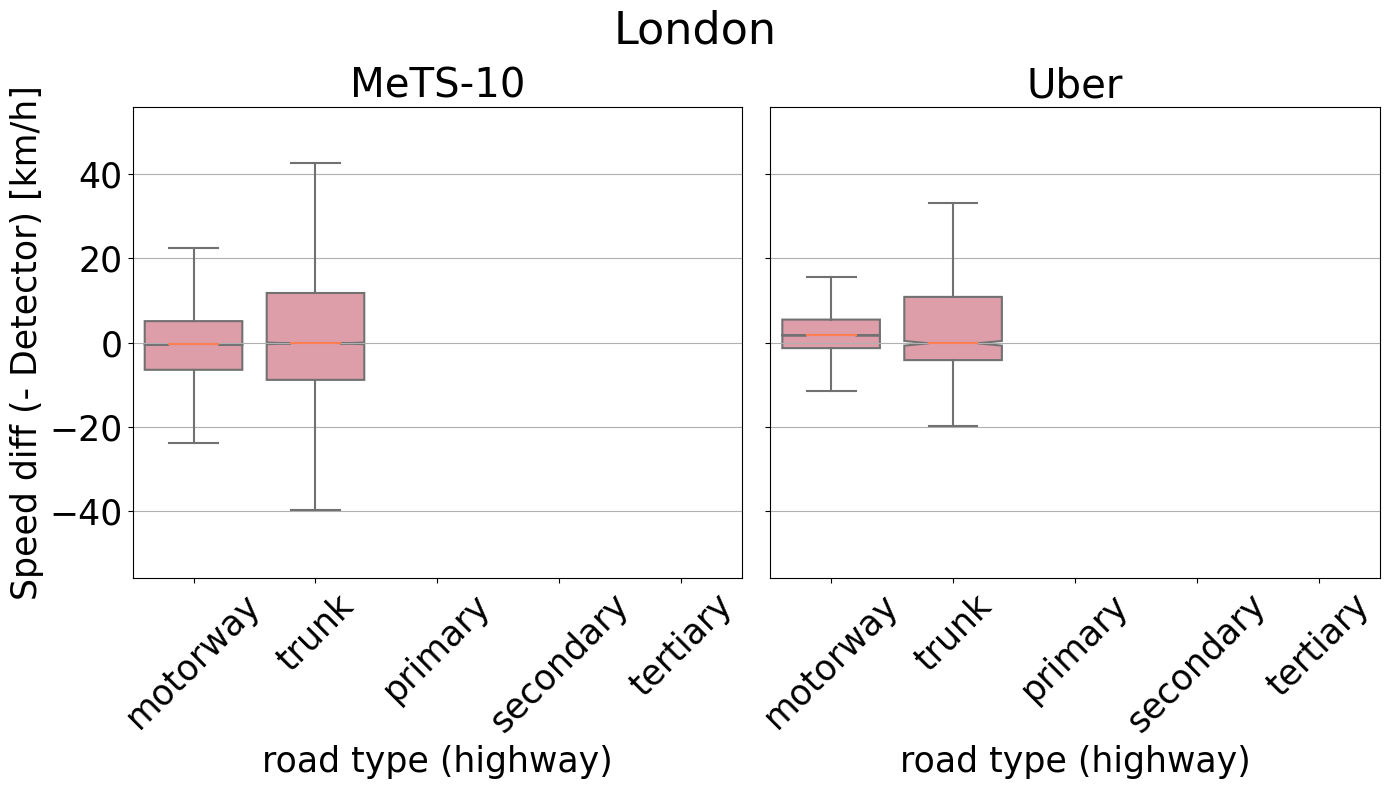

In [81]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(14,8))
diff_boxplot(cm_london_onemonth, axs[0], labelsize=25, city='MeTS-10', y_label='Speed diff (- Detector) [km/h]', speed_field='speed_probes')
diff_boxplot(usm_london_onemonth, axs[1], labelsize=25, city='Uber', y_label='Speed diff (- Detector) [km/h]', speed_field='speed_kph_mean')
axs[1].get_yaxis().set_ticklabels([])
axs[1].set_ylabel('')
fig.suptitle('London', fontsize=32)
plt.savefig("plots/counter_diffs_sxs_london_onemonth.png")
plt.savefig("plots/counter_diffs_sxs_london_onemonth.pdf")

In [95]:
diff_stats_london_onemonth

,highway,diff_mean,diff_std,diff_median,diff_iqr25,diff_iqr75,value_count
0,motorway,3.056858,6.926557,2.273585,-1.131806,6.270245,50777
1,motorway_link,-18.300085,15.978163,-16.496598,-28.037813,-7.535295,3275
2,trunk,3.906163,11.074098,2.583295,-2.276377,10.516522,1834
3,trunk_link,-27.639927,12.654695,-27.497865,-35.920756,-20.148491,339
4,TOTAL,1.655479,9.667750,1.873293,-1.888289,6.062858,56225


In [118]:
print(diff_stats_london_onemonth.to_latex())

\begin{table}
\caption{London 30 days (CounterDiff Uber - CounterDiff MeTS-10)}
\begin{tabular}{llrrrrrr}
 & highway & diff_mean & diff_std & diff_median & diff_iqr25 & diff_iqr75 & value_count \\
0 & motorway & 3.056858 & 6.926557 & 2.273585 & -1.131806 & 6.270245 & 50777 \\
1 & motorway_link & -18.300085 & 15.978163 & -16.496598 & -28.037813 & -7.535295 & 3275 \\
2 & trunk & 3.906163 & 11.074098 & 2.583295 & -2.276377 & 10.516522 & 1834 \\
3 & trunk_link & -27.639927 & 12.654695 & -27.497865 & -35.920756 & -20.148491 & 339 \\
4 & TOTAL & 1.655479 & 9.667750 & 1.873293 & -1.888289 & 6.062858 & 56225 \\
\end{tabular}
\end{table}



/var/folders/zg/l5sgc79n5h508n79m815wzdw0000gn/T/ipykernel_86257/1181734247.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff_uber"] = df['speed_kph_mean'] - df['speed_counter']
/var/folders/zg/l5sgc79n5h508n79m815wzdw0000gn/T/ipykernel_86257/1181734247.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff_mets"] = df['speed_probes'] - df['speed_counter']
/var/folders/zg/l5sgc79n5h508n79m815wzdw0000gn/T/ipykernel_86257/1181734247.py:4: SettingWithCopyWarning: 
A value is trying to be set o

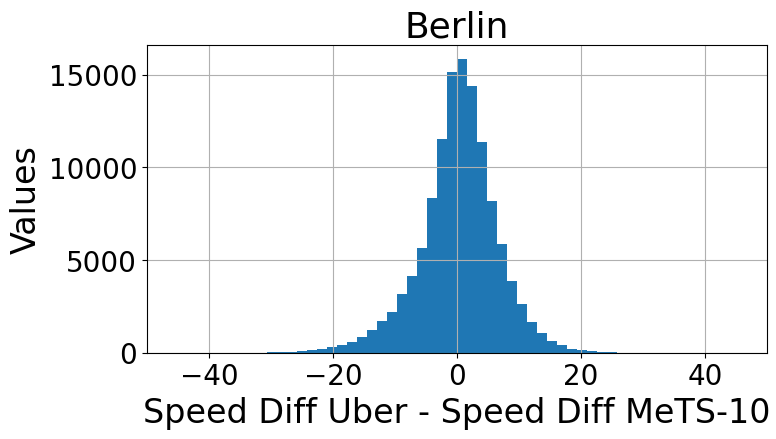

In [124]:
def diff_hist(df, city):
    df["diff_uber"] = df['speed_kph_mean'] - df['speed_counter']
    df["diff_mets"] = df['speed_probes'] - df['speed_counter']
    df["diffdiff"] = df['diff_uber'] - df['diff_mets']
    ax = df["diffdiff"].hist(bins=50, figsize=(8,4))
    ax.set(xlim=(-50, 50))
    ax.set_xlabel('Speed Diff Uber - Speed Diff MeTS-10', fontsize=24)
    ax.set_ylabel('Values', fontsize=24)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.title.set_text(city)
    ax.title.set_size(26)
    plt.savefig(f"plots/counter_diff_stats_{city.lower()}_onemonth.png")
    plt.savefig(f"plots/counter_diff_stats_{city.lower()}_onemonth.pdf")
    
diff_hist(usm_berlin_onemonth, 'Berlin')

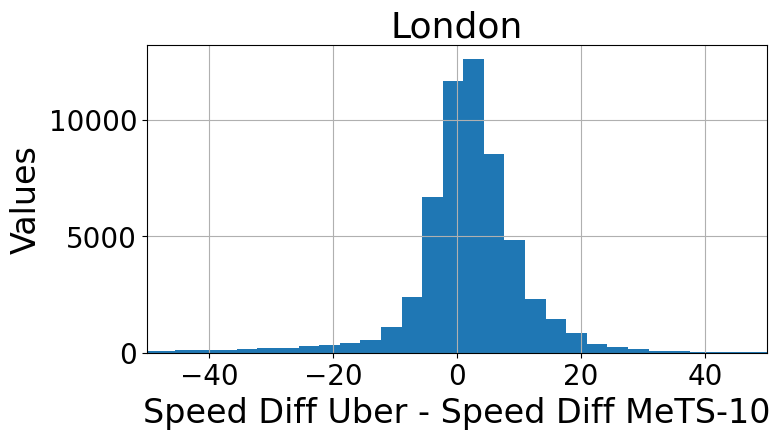

In [125]:
diff_hist(usm_london_onemonth, 'London')

# Counter situation plots

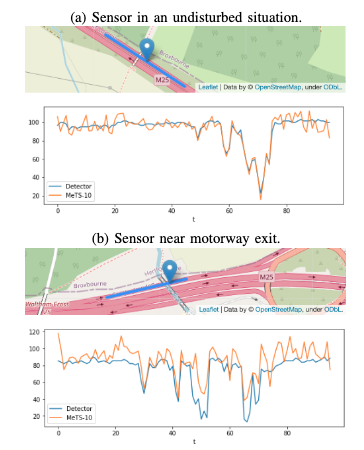

In [4]:
speeds_merged_london_all = pd.read_parquet('speeds_merged_london.parquet')
edges_london = geopandas.read_parquet(DATA_PATH / 'road_graph' / 'london' / 'road_graph_freeflow.parquet')

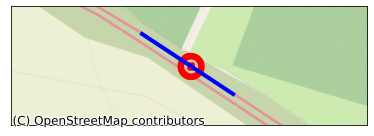

In [16]:
def plot_counter_marker(df, edf, id, ax=None, w=3):
    fig = None
    if not ax:
        fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(9,2))
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    df = df[['id', 'lat', 'lon', 'u', 'v', 'gkey']].groupby(['id', 'lat', 'lon']).max().reset_index()
    df = df[df['id'] == id]
    assert len(df) == 1
    df = geopandas.GeoDataFrame(df.copy(), geometry=geopandas.points_from_xy(df.lon, df.lat))
    df = df.set_crs('EPSG:4326')
    
    edf = edf.merge(df[['id', 'u', 'v', 'gkey']], on=['u', 'v', 'gkey'])
    edf = edf[edf['id'] == id]
    edf = edf.set_crs('EPSG:4326')
    assert len(edf) == 1
    
    df = pd.concat([edf, df])
    df = df.to_crs(epsg=3857)
    
    df.plot(color=['blue', 'red'], marker='$\odot$', markersize=700, linewidth=4, ax=ax)
    
    lat = df.geometry.values[1].y
    lon = df.geometry.values[1].x
    s = 200
    ax.set_xlim([lon-w*s,lon+w*s])
    ax.set_ylim([lat-s,lat+s])
    
    cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, attribution_size=12, reset_extent=True)
    

plot_counter_marker(speeds_merged_london_all, edges_london, '6137')

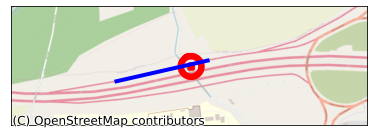

In [6]:
plot_counter_marker(speeds_merged_london_all, edges_london, '1737')

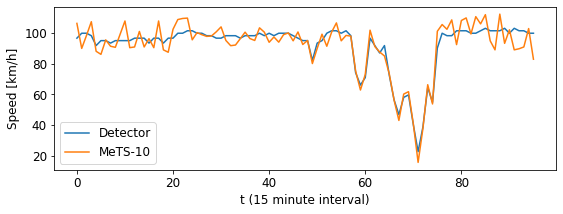

In [387]:
# London easy situation
plot_speed_dayline(speeds_merged_london_all, '6137', figsize=(9,3), labels={'speed_counter': 'Detector', 'speed_probes': 'MeTS-10'})

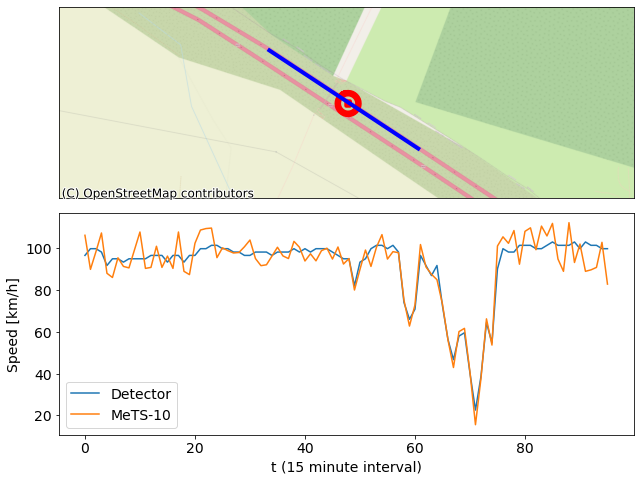

In [388]:
fig, axs = plt.subplots(2, 1, figsize=(9, 7), tight_layout=True)
plot_counter_marker(speeds_merged_london_all, edges_london, '6137', ax=axs[0])
plot_speed_dayline(speeds_merged_london_all, '6137', labels={'speed_counter': 'Detector', 'speed_probes': 'MeTS-10'},
                   labelsize=14, ax=axs[1])
plt.savefig("counter_situation_easy.pdf")

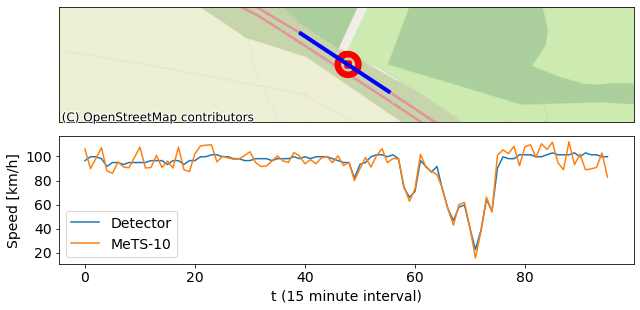

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(9, 4.5), tight_layout=True)
plot_counter_marker(speeds_merged_london_all, edges_london, '6137', ax=axs[0], w=5)
plot_speed_dayline(speeds_merged_london_all, '6137', labels={'speed_counter': 'Detector', 'speed_probes': 'MeTS-10'},
                   labelsize=14, ax=axs[1])
plt.savefig("counter_situation_easy_small.pdf")

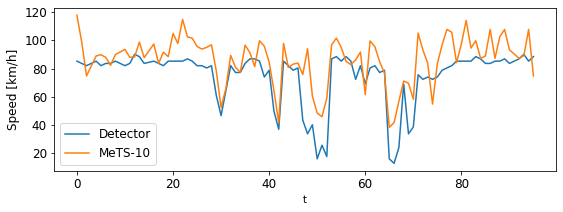

In [380]:
# London crowded situation
plot_speed_dayline(speeds_merged_london_all, '1737', figsize=(9,3), labels={'speed_counter': 'Detector', 'speed_probes': 'MeTS-10'})

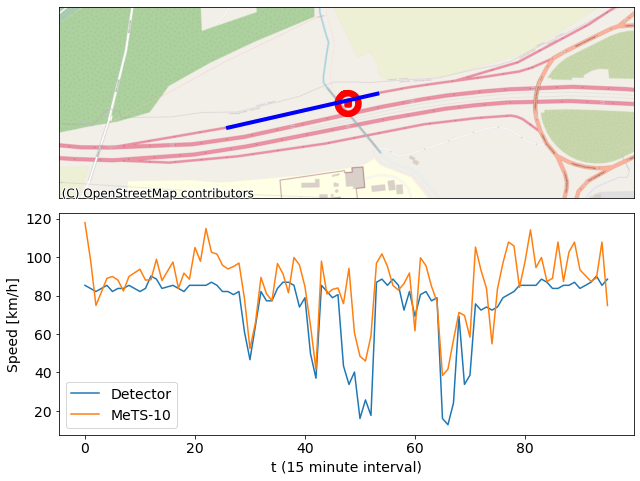

In [389]:
fig, axs = plt.subplots(2, 1, figsize=(9, 7), tight_layout=True)
plot_counter_marker(speeds_merged_london_all, edges_london, '1737', ax=axs[0])
plot_speed_dayline(speeds_merged_london_all, '1737', labels={'speed_counter': 'Detector', 'speed_probes': 'MeTS-10'}, 
                   labelsize=14, ax=axs[1])
plt.savefig("counter_situation_flaky.pdf")

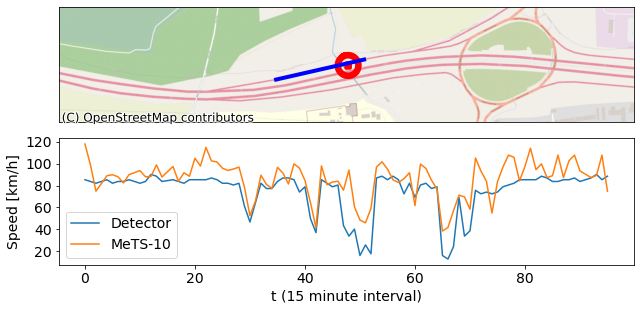

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(9, 4.5), tight_layout=True)
plot_counter_marker(speeds_merged_london_all, edges_london, '1737', ax=axs[0], w=5)
plot_speed_dayline(speeds_merged_london_all, '1737', labels={'speed_counter': 'Detector', 'speed_probes': 'MeTS-10'}, 
                   labelsize=14, ax=axs[1])
plt.savefig("counter_situation_flaky_small.pdf")